1) check weights which are zero for 4b : none
2) check why weights for 2b are all the same
3) check bug in coffea_to_parquet (print the weights)
4) probability difference histo-> zoom at 0
5) zoom on the fpr and tpr in the 0.8-1 area


In [1]:
from collections import defaultdict
import awkward as ak
import numba
import numpy as np
import pandas as pd
import h5py
import vector
vector.register_numba()
vector.register_awkward()

import matplotlib.pyplot as plt
#from matplotlib.colors import LogNorm
#import mplhep as hep
#hep.style.use(hep.style.ROOT)

from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib
matplotlib.rcParams["figure.dpi"] = 300

## Loading the datasets

In [2]:
filename= "/afs/cern.ch/user/r/ramellar/public/inputs_files/output_JetGood_train.h5"
# test= "/eos/home-r/ramellar/5_inputs/probably_2b_data_full/output_JetGood_train.h5"


# df_pred_test= h5py.File(test, "r")
df_pred_2b_data_full= h5py.File(filename, "r")
print(len(df_pred_2b_data_full["CLASSIFICATIONS"]["EVENT"]["signal"][()]))
print(len(df_pred_2b_data_full["INPUTS"]["Event"]["Second_best_pairing_probabilities"][()]))


5368646
5368646


In [3]:
path="/eos/home-r/ramellar/4_classification/variability_study/predictions/"
# filename_test_4b_QCD= "/afs/cern.ch/user/r/ramellar/public/inputs_files/spanet_classifier_4b_QCD/output_JetGood_test.h5"
filename_pred_4v_proba_dnn_4b_QCD=  path + "spanet_prediction_c_dnn_proba_4bQCD_seed0.h5"
filename_pred_4v_proba_dnn_4b_QCD_1=  path + "spanet_prediction_c_dnn_proba_4bQCD_seed1_1.h5"
filename_pred_4v_proba_dnn_4b_QCD_2=  path + "spanet_prediction_c_dnn_proba_4bQCD_seed1_2.h5"
filename_pred_4v_dnn_4b_QCD_2=  path + "spanet_pred_dnn_c_4b_QCD.h5"

# df_test_4b_QCD = h5py.File(filename_test_4b_QCD, "r")
df_pred_4b_QCD = h5py.File(filename_pred_4v_proba_dnn_4b_QCD, "r")
df_pred_4b_QCD_1 = h5py.File(filename_pred_4v_proba_dnn_4b_QCD_1, "r")
df_pred_4b_QCD_1_2 = h5py.File(filename_pred_4v_proba_dnn_4b_QCD_2, "r")
df_pred_4b_QCD_dnn = h5py.File(filename_pred_4v_dnn_4b_QCD_2, "r")

list_pred= [df_pred_4b_QCD, df_pred_4b_QCD_1, df_pred_4b_QCD_1_2, df_pred_4b_QCD_dnn]
list_labels= ["seed 0", "seed 1", "seed 1.1", "dnn only as input"]


In [7]:
path_i="/eos/home-r/ramellar/5_inputs/"
filename_test_4b_QCD=path_i+"spanet_classifier_4b_QCD_working/output_JetGood_test.h5"
filename_test_2b_QCD=path_i+"spanet_classifier_2b_QCD/output_JetGood_test.h5"

path_p="/eos/home-r/ramellar/4_classification/classification_predictions/"
filename_pred_4v_dnn_4b_QCD= path_p + "spanet_c_4v_dnn.h5"
filename_pred_4v_dnn_proba_4b_QCD= path_p + "spanet_c_4v_dnn_proba.h5"

df_test_4b_QCD= h5py.File(filename_test_4b_QCD, "r")
df_test_2b_QCD= h5py.File(filename_test_2b_QCD, "r")
df_pred_4v_dnn_4b_QCD =h5py.File(filename_pred_4v_dnn_4b_QCD, "r")
df_pred_4v_dnn_proba_4b_QCD =h5py.File(filename_pred_4v_dnn_proba_4b_QCD, "r")

list_pred= [df_pred_4v_dnn_proba_4b_QCD, df_pred_4v_dnn_4b_QCD]
list_labels= ["4b QCD DNN vars and prob diff", "4b QCD DNN vars"]

print(len(df_pred_4v_dnn_4b_QCD["CLASSIFICATIONS"]["EVENT"]["signal"][()]))
print(len(df_pred_4v_dnn_proba_4b_QCD["CLASSIFICATIONS"]["EVENT"]["signal"][()]))
print(len(df_test_4b_QCD["CLASSIFICATIONS"]["EVENT"]["signal"][()]))
print(len(df_test_2b_QCD["CLASSIFICATIONS"]["EVENT"]["signal"][()]))


179556
179556
183717
183596


In [6]:
# filename_test= "/afs/cern.ch/user/r/ramellar/public/inputs_files/spanet_classifier_prediction_dnn/output_JetGood_test.h5"
# filename_test_old_model= "/afs/cern.ch/user/r/ramellar/public/inputs_files/output_JetGood_test.h5"
# filename_test_2b_data= "/afs/cern.ch/user/r/ramellar/public/inputs_files/spanet_classifier_2b_data/output_JetGood_test.h5"
# filename_test_2b_QCD= "/afs/cern.ch/user/r/ramellar/public/inputs_files/spanet_classifier_2b_QCD/output_JetGood_test.h5"

# filename_train= "/afs/cern.ch/user/r/ramellar/public/inputs_files/spanet_classifier_prediction_dnn/output_JetGood_train.h5"
# filename_pred_4v_dnn="/afs/cern.ch/user/r/ramellar/HH4b_SPANet/spanet_c_4v_dnn.h5"
# filename_pred_4v_dnn_proba="/afs/cern.ch/user/r/ramellar/HH4b_SPANet/spanet_c_4v_dnn_proba.h5"
# filename_pred_4v_dnn_2b_data="/afs/cern.ch/user/r/ramellar/HH4b_SPANet/spanet_c_4v_dnn_2b_data_out.h5"
# filename_pred_4v_proba_dnn_2b_data="/afs/cern.ch/user/r/ramellar/HH4b_SPANet/spanet_c_4v_dnn_proba_2b_data_out.h5"
# filename_pred_4v_dnn_2b_QCD="/afs/cern.ch/user/r/ramellar/HH4b_SPANet/spnet_prediction_c_dnn_QCD_new.h5"
# filename_pred_4v_proba_dnn_2b_QCD="/afs/cern.ch/user/r/ramellar/HH4b_SPANet/spnet_prediction_c_dnn_proba_QCD_new.h5"

# #test and train files
# df_train = h5py.File(filename_train,'r')
# df_test_4b_QCD = h5py.File(filename_test,'r')
# df_test_old_model = h5py.File(filename_test_old_model,'r')
# df_test_2b_data = h5py.File(filename_test_2b_data,'r')
# df_test_2b_QCD = h5py.File(filename_test_2b_QCD,'r')

# #prediction files
# df_pred_2b_data = h5py.File(filename_pred_4v_dnn_2b_data,'r')
# df_pred_2b_data_proba_dnn = h5py.File(filename_pred_4v_proba_dnn_2b_data,'r')
# df_pred_2b_QCD = h5py.File(filename_pred_4v_dnn_2b_QCD,'r')
# df_pred_2b_QCD_proba_dnn = h5py.File(filename_pred_4v_proba_dnn_2b_QCD,'r')
# df_pred_4v_proba_dnn = h5py.File(filename_pred_4v_dnn_proba,'r')
# df_pred_4v_dnn = h5py.File(filename_pred_4v_dnn,'r')

In [ ]:
# filename_test="/afs/cern.ch/user/r/ramellar/public/inputs_files/spanet_classifier_prediction_ht/output_JetGood_test.h5"
# filename_pred_local="/afs/cern.ch/user/r/ramellar/HH4b_SPANet/spanet_c_4v_out_local.h5"
# filename_pred_nobtag_mass="/afs/cern.ch/user/r/ramellar/HH4b_SPANet/spanet_c_4v_out.h5"
# filename_4v_proba="/afs/cern.ch/user/r/ramellar/HH4b_SPANet/spanet_c_4v_proba_out.h5"

# df_test = h5py.File(filename_test,'r')
# df_pred_local = h5py.File(filename_pred_local,'r')
# df_pred_no_btag_mass = h5py.File(filename_pred_nobtag_mass,'r')
# df_pred_4v_proba = h5py.File(filename_4v_proba,'r')

# list_pred =[df_pred,df_pred_no_btag_mass, df_pred_4v_proba]
# list_labels=["No btag with mass trained locally", "No btag with mass trained on condor", "4 vector info with probability difference"]


# list_pred =[df_pred_no_btag_mass, df_pred_4v_proba]
# list_labels=["4 vector", "4 vector and probability difference"]

# list_pred =[df_pred_4v_proba_dnn, df_pred_4v_proba, df_pred_4v_dnn]
# list_labels=["4 vector, probability difference and all DNN vars", "4 vector and probability difference", "4 vector and DNN vars"]


## ROC curve points from the AN

In [ ]:
roc_points_0= "/afs/cern.ch/user/r/ramellar/public/inputs_files/roc_raffaele/roc_points_era_1_fold_0.npy"
roc_points_1= "/afs/cern.ch/user/r/ramellar/public/inputs_files/roc_raffaele/roc_points_era_1_fold_1.npy"
df_roc_0 = np.load(roc_points_0)
df_roc_1 = np.load(roc_points_1)

In [ ]:
fpr_r=df_roc_0[:,0]
tpr_r=df_roc_0[:,1]
print(df_roc_0[:,0])
print(df_roc_0[:,1])

[0.         0.         0.         ... 0.99999492 0.99999696 1.        ]
[0.00000000e+00 1.82424163e-08 2.66156854e-05 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


In [ ]:
#define signal events
# mask_signal=df_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==1
# define background events
# mask_background=df_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==0

# probabilities_signal=df_pred["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()]

# print(probabilities_signal)

In [ ]:
# proba_signal_signal=probabilities_signal[mask_signal]
# proba_signal_background=probabilities_signal[mask_background]

In [ ]:
# plt.hist(proba_signal_signal,bins=100,range=(0,1),histtype='step',label="Signal", density=True)
# plt.hist(proba_signal_background,bins=100,range=(0,1),histtype='step',label="Background", density=True)
# plt.legend()
# plt.show()

In [ ]:
# true=df_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]
# roc_auc_score(true,probabilities_signal)
# print(probabilities_signal)

# len(true)

# fpr, tpr, thresholds = roc_curve(true, probabilities_signal)

# print(fpr)

# plt.plot(tpr,fpr)
# plt.grid()
# plt.show()

In [ ]:
# len(true)

# np.sum((true))/len(true)

In [ ]:
# roc_auc_score(true,probabilities_signal)

## Probability distributions

In [ ]:
def probabilities(dataset_test, dataset_pred, name, title):
    mask_signal=dataset_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==1
    mask_background=dataset_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==0
    prob_signal=dataset_pred["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()]
    proba_signal_signal=prob_signal[mask_signal]
    proba_signal_background=prob_signal[mask_background]
    weights_signal= dataset_test["WEIGHTS"]['weight'][()][mask_signal]
    print("dataset", dataset_test)
    print("bckg", len(proba_signal_background))
    print("signal", len(proba_signal_signal))
    weights_bckg= dataset_test["WEIGHTS"]['weight'][()][mask_background]
    print(weights_bckg)
    fig= plt.figure()
    plt.hist(proba_signal_signal,bins=100,range=(0,1),histtype='step',label="Signal", density=True)
    plt.hist(proba_signal_background,bins=100,range=(0,1),histtype='step',label="Background", density=True)
    plt.hist(proba_signal_signal,bins=100,range=(0,1),histtype='step',label="Signal weighted", density=True, weights=weights_signal)
    plt.hist(proba_signal_background,bins=100,range=(0,1),histtype='step',label="Background weighted", density=True, weights=weights_bckg)
    plt.title(f"{title}")
    plt.legend()
    plt.yscale("log")
    plt.savefig(f"/afs/cern.ch/user/r/ramellar/HH4b_SPANet/classification_plots/signal_proba_{name}")
    plt.close(fig)
    return proba_signal_signal, proba_signal_background

weights_bckg [2.5648554e-08 4.9550413e-09 6.7160315e-08 ... 2.5605189e-08 2.5838952e-08
 1.6260273e-07]


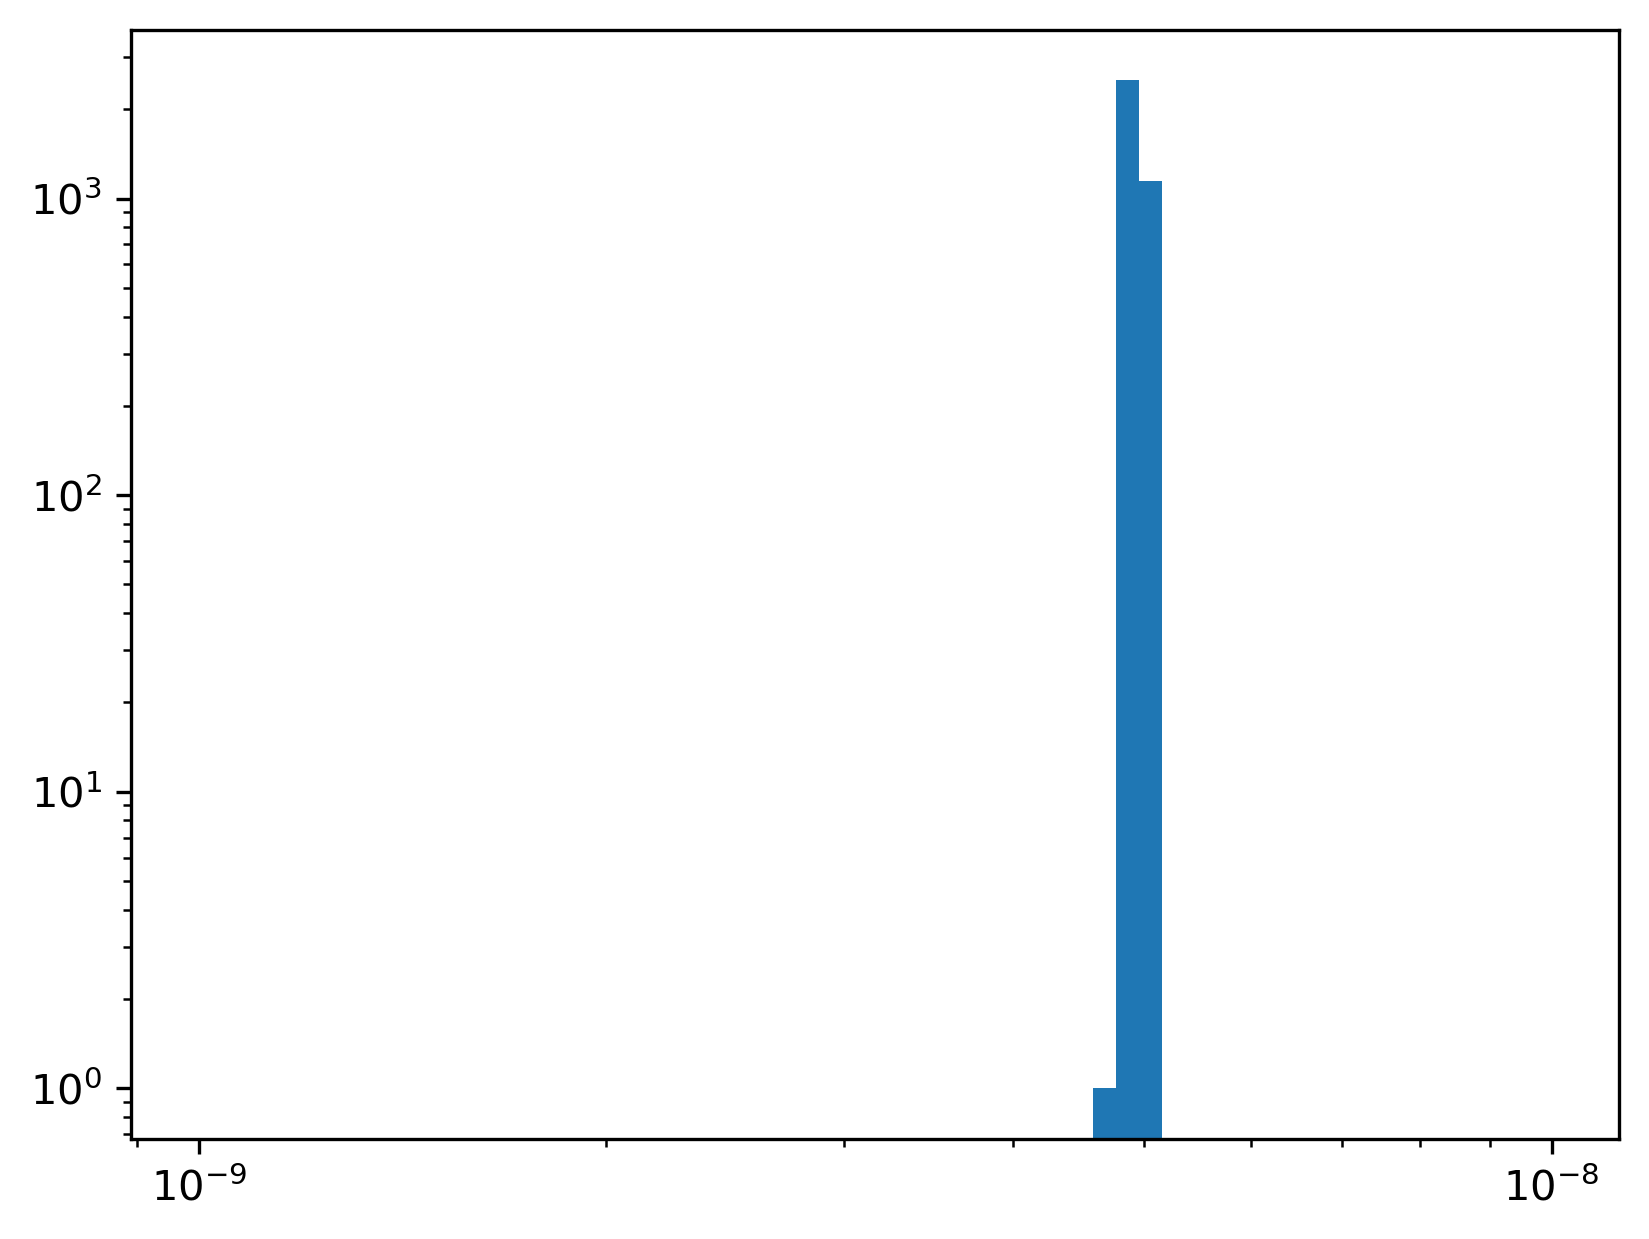

In [ ]:
mask_signal=df_test_2b_QCD["CLASSIFICATIONS"]["EVENT"]["signal"][()]==1
mask_background=df_test_2b_QCD["CLASSIFICATIONS"]["EVENT"]["signal"][()]==0
weights_signal= df_test_2b_QCD["WEIGHTS"]['weight'][()][mask_signal]
weights_bckg= df_test_2b_QCD["WEIGHTS"]['weight'][()][mask_background]

print("weights_bckg", weights_bckg)
plt.hist(weights_bckg, np.logspace(-9,-8,60))
plt.yscale("log")
plt.xscale("log")
plt.show()



weights_bckg [6.5741240e-08 2.5473813e-08 6.6251843e-08 ... 6.0745452e-07 1.6130312e-07
 4.8039119e-09]


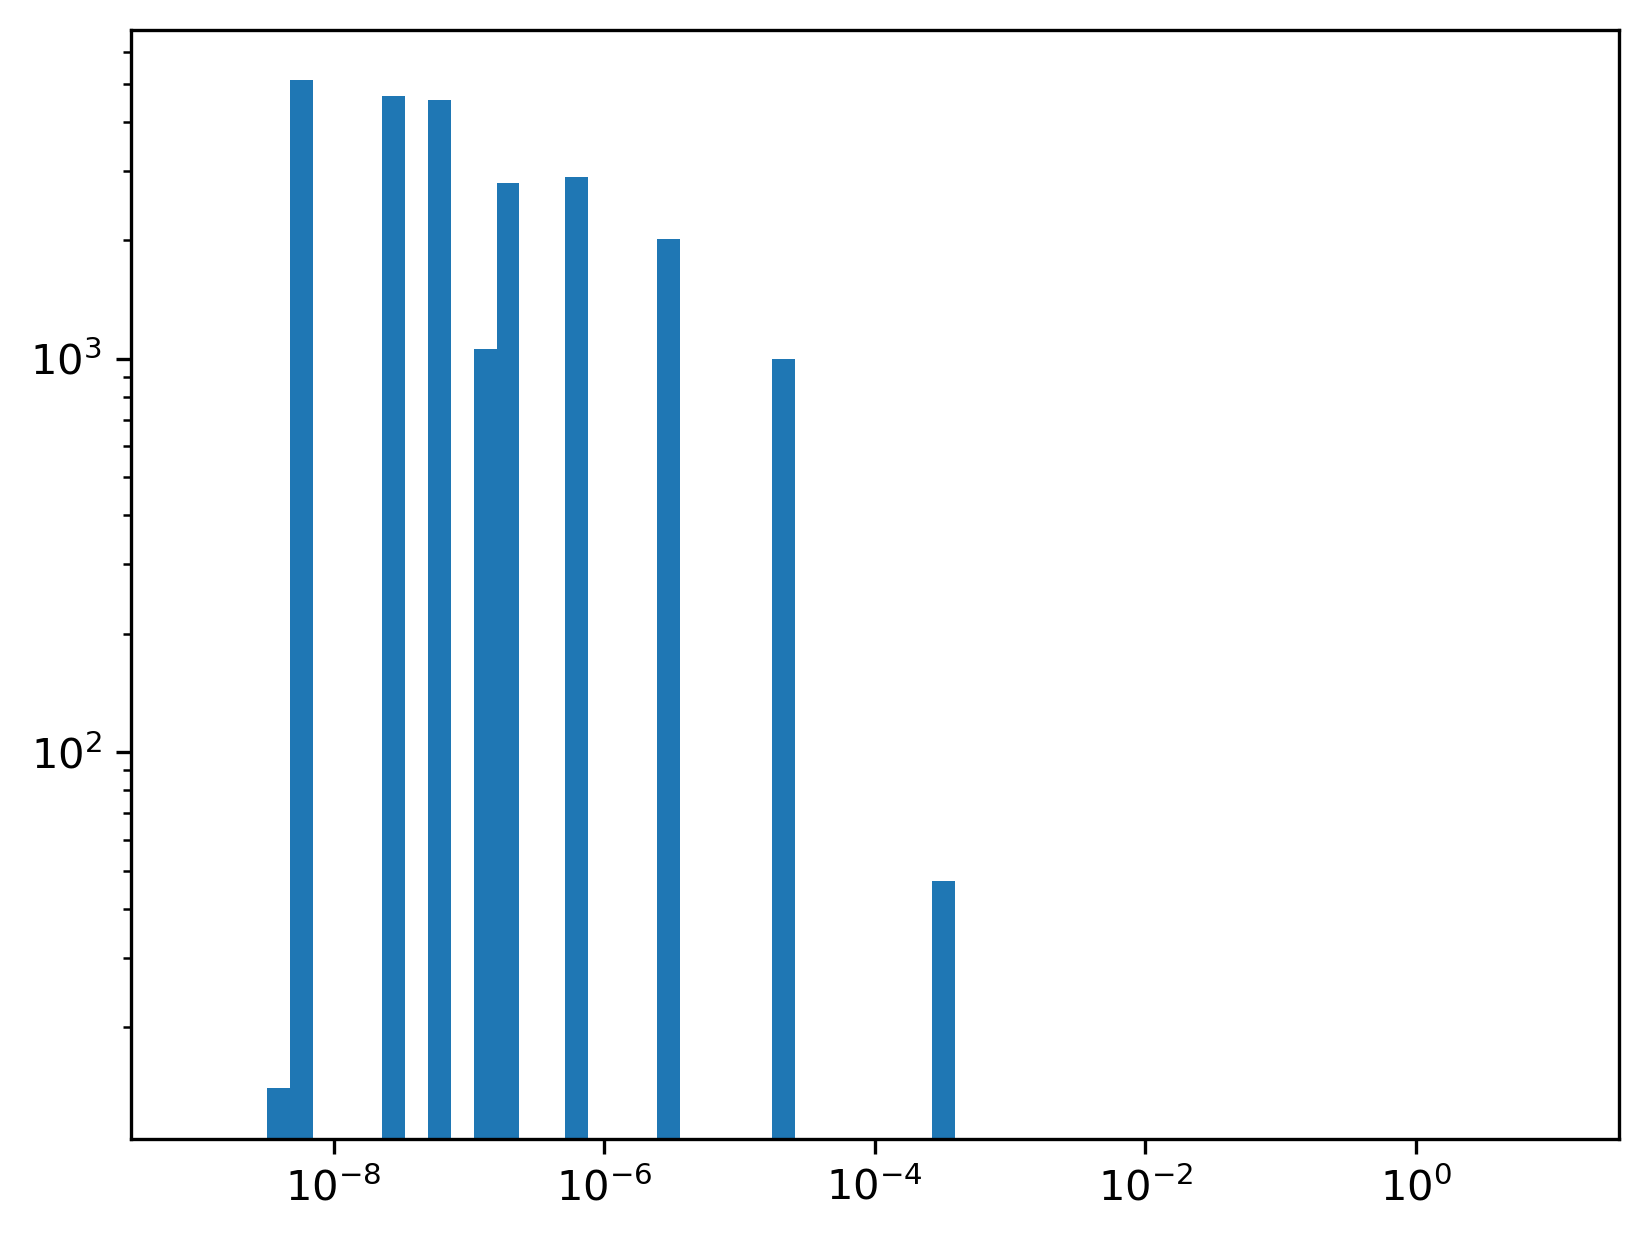

In [ ]:
mask_signal=df_test_4b_QCD["CLASSIFICATIONS"]["EVENT"]["signal"][()]==1
mask_background=df_test_4b_QCD["CLASSIFICATIONS"]["EVENT"]["signal"][()]==0
weights_signal= df_test_4b_QCD["WEIGHTS"]['weight'][()][mask_signal]
weights_bckg= df_test_4b_QCD["WEIGHTS"]['weight'][()][mask_background]
print("weights_bckg", weights_bckg)
plt.hist(weights_bckg, np.logspace(-9,1,60))
plt.yscale("log")
plt.xscale("log")
plt.show()

In [ ]:
zeros=np.zeros_like(weights_bckg)
print(zeros.dtype)
print(sum(weights_bckg==zeros))

float32
0


In [ ]:
probabilities(df_test_4b_QCD, df_pred_4v_proba_dnn,"4b_QCD_proba_dnn", "Signal probability distribution for 4b QCD with DNN vars and proba diff")
probabilities(df_test_4b_QCD, df_pred_4v_dnn, "4b_QCD_dnn", "Signal probability distribution for 4b QCD with DNN vars")
probabilities(df_test_2b_QCD, df_pred_2b_QCD, "2b_QCD_dnn", "Signal probability distribution for 2b QCD with DNN vars")
probabilities(df_test_2b_QCD, df_pred_2b_QCD_proba_dnn, "2b_QCD_proba_dnn", "Signal probability distribution for 2b QCD with DNN vars and prob diff")
probabilities(df_test_2b_data, df_pred_2b_data, "2b_data_dnn", "Signal probability distribution for 2b data with DNN vars")
probabilities(df_test_2b_data, df_pred_2b_data_proba_dnn, "2b_data_dnn_proba", "Signal probability distribution for 2b data with DNN vars and prob diff")


dataset <HDF5 file "output_JetGood_test.h5" (mode r)>
bckg 24121
signal 155435
[6.5741240e-08 2.5473813e-08 6.6251843e-08 ... 6.0745452e-07 1.6130312e-07
 4.8039119e-09]
dataset <HDF5 file "output_JetGood_test.h5" (mode r)>
bckg 24121
signal 155435
[6.5741240e-08 2.5473813e-08 6.6251843e-08 ... 6.0745452e-07 1.6130312e-07
 4.8039119e-09]
dataset <HDF5 file "output_JetGood_test.h5" (mode r)>
bckg 24340
signal 159256
[2.5648554e-08 4.9550413e-09 6.7160315e-08 ... 2.5605189e-08 2.5838952e-08
 1.6260273e-07]
dataset <HDF5 file "output_JetGood_test.h5" (mode r)>
bckg 24340
signal 159256
[2.5648554e-08 4.9550413e-09 6.7160315e-08 ... 2.5605189e-08 2.5838952e-08
 1.6260273e-07]
dataset <HDF5 file "output_JetGood_test.h5" (mode r)>
bckg 24226
signal 159370
[1.6909745e-07 1.6909745e-07 1.6909745e-07 ... 1.6909745e-07 1.6909745e-07
 1.6909745e-07]
dataset <HDF5 file "output_JetGood_test.h5" (mode r)>
bckg 24226
signal 159370
[1.6909745e-07 1.6909745e-07 1.6909745e-07 ... 1.6909745e-07 1.6909745e

(array([0.98891884, 0.998558  , 0.9967037 , ..., 0.9953636 , 0.9950529 ,
        0.8658885 ], dtype=float32),
 array([0.23151055, 0.00153746, 0.02629382, ..., 0.05274255, 0.0220653 ,
        0.02192322], dtype=float32))

## ROC curves comparisons

In [20]:
def roc_curve_compare_no_weights(list_test,list_pred,list_labels,name):
    true= [t["CLASSIFICATIONS"]["EVENT"]["signal"][()] for t in list_test]
    proba_signal= [pred["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()] for pred in list_pred]
    print(len(proba_signal))
    weights= [t["WEIGHTS"]['weight'][()] for t in list_test]
    score= [roc_auc_score(true[i], proba_signal[i], sample_weight= weights[i]) for i in range(len(proba_signal))]
    print(score)
    fpr, tpr, thresholds = zip(*[roc_curve(true[i], proba_signal[i], sample_weight=weights[i]) for i in range(len(proba_signal))])
    fig=plt.figure()
    for i in range(len(fpr)):
        plt.plot(tpr[i],fpr[i],label=f"{list_labels[i]} with AUC={score[i]:.3f}")
        plt.legend(fontsize= 'small')
        plt.xlabel("tpr")
        plt.ylabel("fpr")
        plt.grid(linestyle=":")
        # plt.title(f"{title}")
    plt.savefig(f"/afs/cern.ch/user/r/ramellar/HH4b_SPANet/{name}")
    plt.close(fig)
    
# list_test=[df_test_4b_QCD, df_test_4b_QCD, df_test_4b_QCD]
# list_pred =[df_pred_4v_proba_dnn, df_pred_4v_proba, df_pred_4v_dnn]
# list_labels=["4 vector, probability difference and all DNN vars", "4 vector and probability difference", "4 vector and DNN vars"]
# roc_curve_compare_no_weights(list_test,list_pred, list_labels, "4b_QCD_diff_inputs")

# list_test=[df_test_4b_QCD, df_test_2b_data, df_test_2b_QCD]
# list_pred =[df_pred_4v_dnn, df_pred_2b_data, df_pred_2b_QCD]
# list_labels=["4b QCD DNN vars", "2b data DNN vars", "2b QCD DNN vars"]
# roc_curve_compare_no_weights(list_test,list_pred, list_labels, "dnn_var_comparison_bckg")

# list_test=[df_test_2b_data, df_test_2b_data]
# list_pred =[df_pred_2b_data_proba_dnn, df_pred_2b_data]
# list_labels=["2b data DNN vars and prob diff", "2b data DNN vars"]
# roc_curve_compare_no_weights(list_test,list_pred, list_labels, "2b_data_input_diff")

# list_test=[df_test_2b_QCD, df_test_2b_QCD]
# list_pred =[df_pred_2b_QCD_proba_dnn, df_pred_2b_QCD]
# list_labels=["2b QCD DNN vars and prob diff", "2b QCD DNN vars"]
# roc_curve_compare_no_weights(list_test,list_pred, list_labels, "2b_QCD_input_diff")

list_test=[df_test_4b_QCD, df_test_4b_QCD]
roc_curve_compare_no_weights(list_test, list_pred, list_labels, "4b_inputs_comparison_w")



2
[0.919609102907431, 0.9293153974359722]


In [ ]:
def roc_curve_compare_weights(list_test,list_pred,list_labels,name):
    true= [t["CLASSIFICATIONS"]["EVENT"]["signal"][()] for t in list_test]
    proba_signal= [pred["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()] for pred in list_pred]
    print(len(proba_signal))
    weights= [t["WEIGHTS"]['weight'][()] for t in list_test]
    score= [roc_auc_score(true[i], proba_signal[i], sample_weight= weights[i]) for i in range(len(proba_signal))]
    print(score)
    fpr, tpr, thresholds = zip(*[roc_curve(true[i], proba_signal[i], sample_weight=weights[i]) for i in range(len(proba_signal))])
    fig=plt.figure()
    for i in range(len(fpr)):
        plt.plot(tpr[i],fpr[i],label=f"{list_labels[i]} with AUC={score[i]:.3f}")
        plt.legend(fontsize= 'small')
        plt.xlabel("tpr")
        plt.ylabel("fpr")
        plt.grid(linestyle=":")
    plt.savefig(f"/afs/cern.ch/user/r/ramellar/HH4b_SPANet/classification_plots/ROC_curves/{name}_w")
    plt.close(fig)
    
list_test=[df_test_4b_QCD, df_test_4b_QCD, df_test_4b_QCD]
list_pred =[df_pred_4v_proba_dnn, df_pred_4v_proba, df_pred_4v_dnn]
list_labels=["4 vector, probability difference and all DNN vars", "4 vector and probability difference", "4 vector and DNN vars"]
roc_curve_compare_weights(list_test,list_pred, list_labels, "4b_QCD_diff_inputs")

list_test=[df_test_4b_QCD, df_test_2b_data, df_test_2b_QCD]
list_pred =[df_pred_4v_dnn, df_pred_2b_data, df_pred_2b_QCD]
list_labels=["4b QCD DNN vars", "2b data DNN vars", "2b QCD DNN vars"]
roc_curve_compare_weights(list_test,list_pred, list_labels, "dnn_var_comparison_bckg")

list_test=[df_test_2b_data, df_test_2b_data]
list_pred =[df_pred_2b_data_proba_dnn, df_pred_2b_data]
list_labels=["2b data DNN vars and prob diff", "2b data DNN vars"]
roc_curve_compare_weights(list_test,list_pred, list_labels, "2b_data_input_diff")

list_test=[df_test_2b_QCD, df_test_2b_QCD]
list_pred =[df_pred_2b_QCD_proba_dnn, df_pred_2b_QCD]
list_labels=["2b QCD DNN vars and prob diff", "2b QCD DNN vars"]
roc_curve_compare_weights(list_test,list_pred, list_labels, "2b_QCD_input_diff")



3
[0.919609102907431, 0.8839510802465564, 0.9293153974359722]
3
[0.9293153974359722, 0.951456097236773, 0.9564971238297794]
2
[0.979127826530546, 0.951456097236773]
2
[0.9778559317976, 0.9564971238297794]


In [ ]:
# def roc_curve_compare_weights(list_test,list_pred,list_labels):
#     true= [t["CLASSIFICATIONS"]["EVENT"]["signal"][()] for t in list_test]
#     proba_signal= [pred["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()] for pred in list_pred]
#     print(len(proba_signal))
#     weights=[test["WEIGHTS"]['weight'][()] for test in list_test]
#     score= [roc_auc_score(true[i], proba_signal[i], sample_weight=weights[i]) for i in range(len(proba_signal))]
#     fpr, tpr, thresholds = zip(*[roc_curve(true[i], proba_signal[i], sample_weight=weights[i]) for i in range(len(proba_signal))])
#     for i in range(len(fpr)):
#         plt.plot(tpr[i],fpr[i],label=f"{list_labels[i]} with AUC={score[i]:.3f}")
#         plt.legend(fontsize= 'small')
#         plt.xlabel("tpr")
#         plt.ylabel("fpr")
#         plt.grid(linestyle=":")
#     plt.show()

# list_test=[df_test_4b_QCD, df_test_2b_data, df_test_2b_QCD]
# list_pred =[df_pred_4v_dnn, df_pred_2b_data, df_pred_2b_QCD]
# list_labels=["4b QCD DNN vars", "2b data DNN vars", "2b QCD DNN vars"]
# roc_curve_compare_weights(list_test,list_pred, list_labels)

## ROC curves

In [4]:
def roc_curve_plot(test_dataset, dataset_pred):
    true=test_dataset["CLASSIFICATIONS"]["EVENT"]["signal"][()]
    print(true)
    proba_signal=dataset_pred["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()]
    print(proba_signal)
    events=test_dataset["CLASSIFICATIONS"]["EVENT"]["signal"][()]
    bckg_events= test_dataset["CLASSIFICATIONS"]["EVENT"]["signal"][()] ==0
    
    weights= test_dataset["WEIGHTS"]['weight'][()]
    print(weights)
    # weights= np.ones_like(weights)
    
    # class_signal_weight=7.8112e-04
    # class_bckg_weight= 1.9998
    
    # adjusted_weights = [
    # weight * class_signal_weight if label == 1 else weight * class_bckg_weight
    # for weight, label in zip(weights, events)
    # ]
    score=roc_auc_score(true, proba_signal, sample_weight=weights)
    score_2=roc_auc_score(true, proba_signal)
    print(score)
    fpr, tpr, thresholds = roc_curve(true, proba_signal, sample_weight=weights)
    fpr_2, tpr_2, thresholds = roc_curve(true, proba_signal)
    plt.plot(tpr,fpr,label=f"AUC={score:.3f} with weights")
    plt.plot(tpr_2,fpr_2,label=f"AUC={score_2:.3f}")
    plt.legend()
    plt.xlabel("tpr")
    # plt.yscale("log")
    plt.ylabel("fpr")
    plt.grid(linestyle=":")
    plt.show()

[1 1 1 ... 1 1 1]
[0.9733879 0.8680956 0.9852705 ... 0.9619111 0.9726581 0.6339713]
[0.0039835 0.0039835 0.0039835 ... 0.0039835 0.0039835 0.0039835]
0.9562253662660509


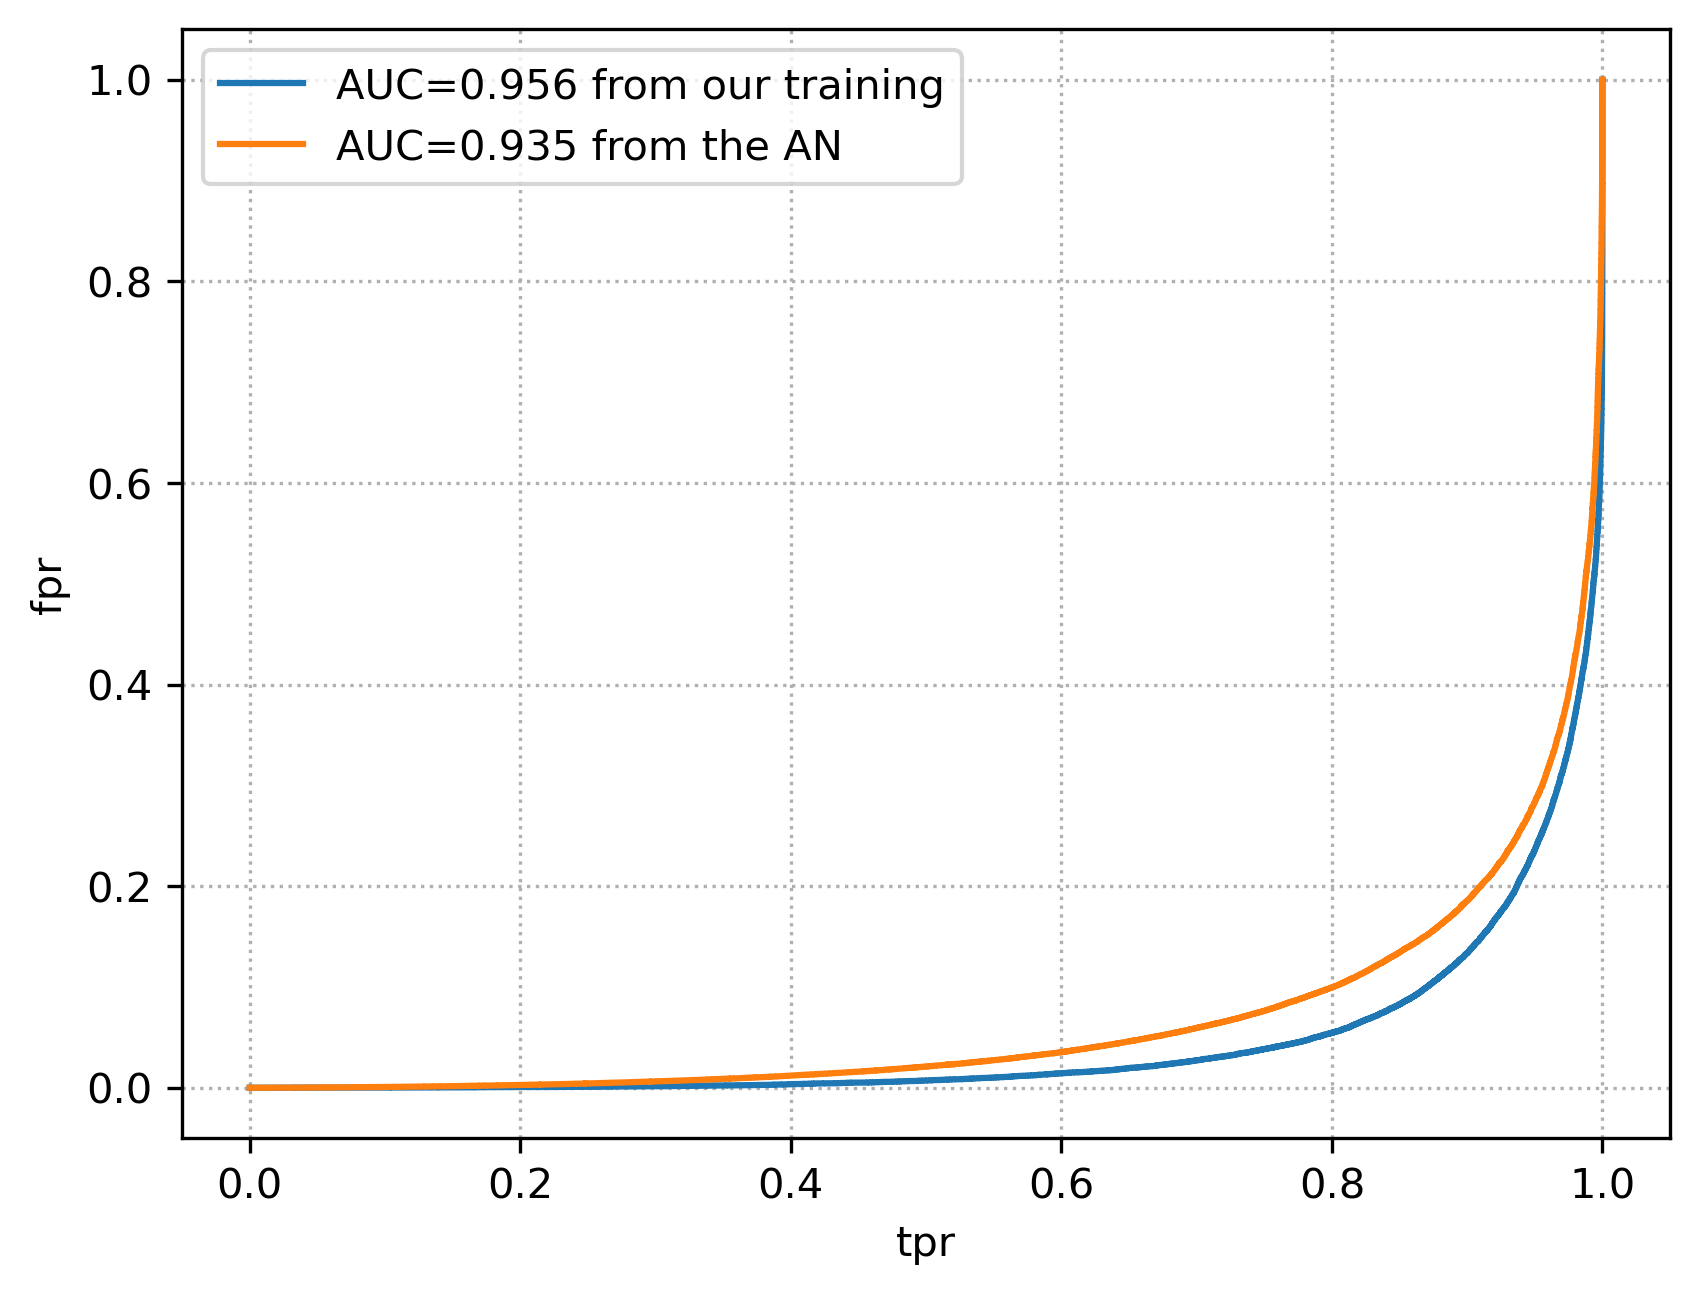

In [ ]:
def roc_curve_plot_comp(test_dataset, dataset_pred):
    true=test_dataset["CLASSIFICATIONS"]["EVENT"]["signal"][()]
    print(true)
    proba_signal=dataset_pred["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()]
    print(proba_signal)
    events=test_dataset["CLASSIFICATIONS"]["EVENT"]["signal"][()]
    bckg_events= test_dataset["CLASSIFICATIONS"]["EVENT"]["signal"][()] ==0
    
    weights= test_dataset["WEIGHTS"]['weight'][()]
    print(weights)
    # weights= np.ones_like(weights)
    
    # class_signal_weight=7.8112e-04
    # class_bckg_weight= 1.9998
    
    # adjusted_weights = [
    # weight * class_signal_weight if label == 1 else weight * class_bckg_weight
    # for weight, label in zip(weights, events)
    # ]
    
    fpr, tpr, thresholds = roc_curve(true, proba_signal)
    fpr_r=df_roc_0[:,0]
    tpr_r=df_roc_0[:,1]
    
    score=roc_auc_score(true, proba_signal)
    score_2=auc(fpr_r, tpr_r)
    print(score)
    
    plt.plot(tpr,fpr,label=f"AUC={score:.3f} from our training")
    plt.plot(tpr_r,fpr_r,label=f"AUC={score_2:.3f} from the AN")
    plt.legend()
    plt.xlabel("tpr")
    # plt.yscale("log")
    plt.ylabel("fpr")
    plt.grid(linestyle=":")
    plt.show()
    
roc_curve_plot_comp(df_test_4b_QCD,df_pred_4v_dnn)

[1 1 1 ... 1 1 1]
[0.9733879 0.8680956 0.9852705 ... 0.9619111 0.9726581 0.6339713]
[0.0039835 0.0039835 0.0039835 ... 0.0039835 0.0039835 0.0039835]
0.9293153974359722


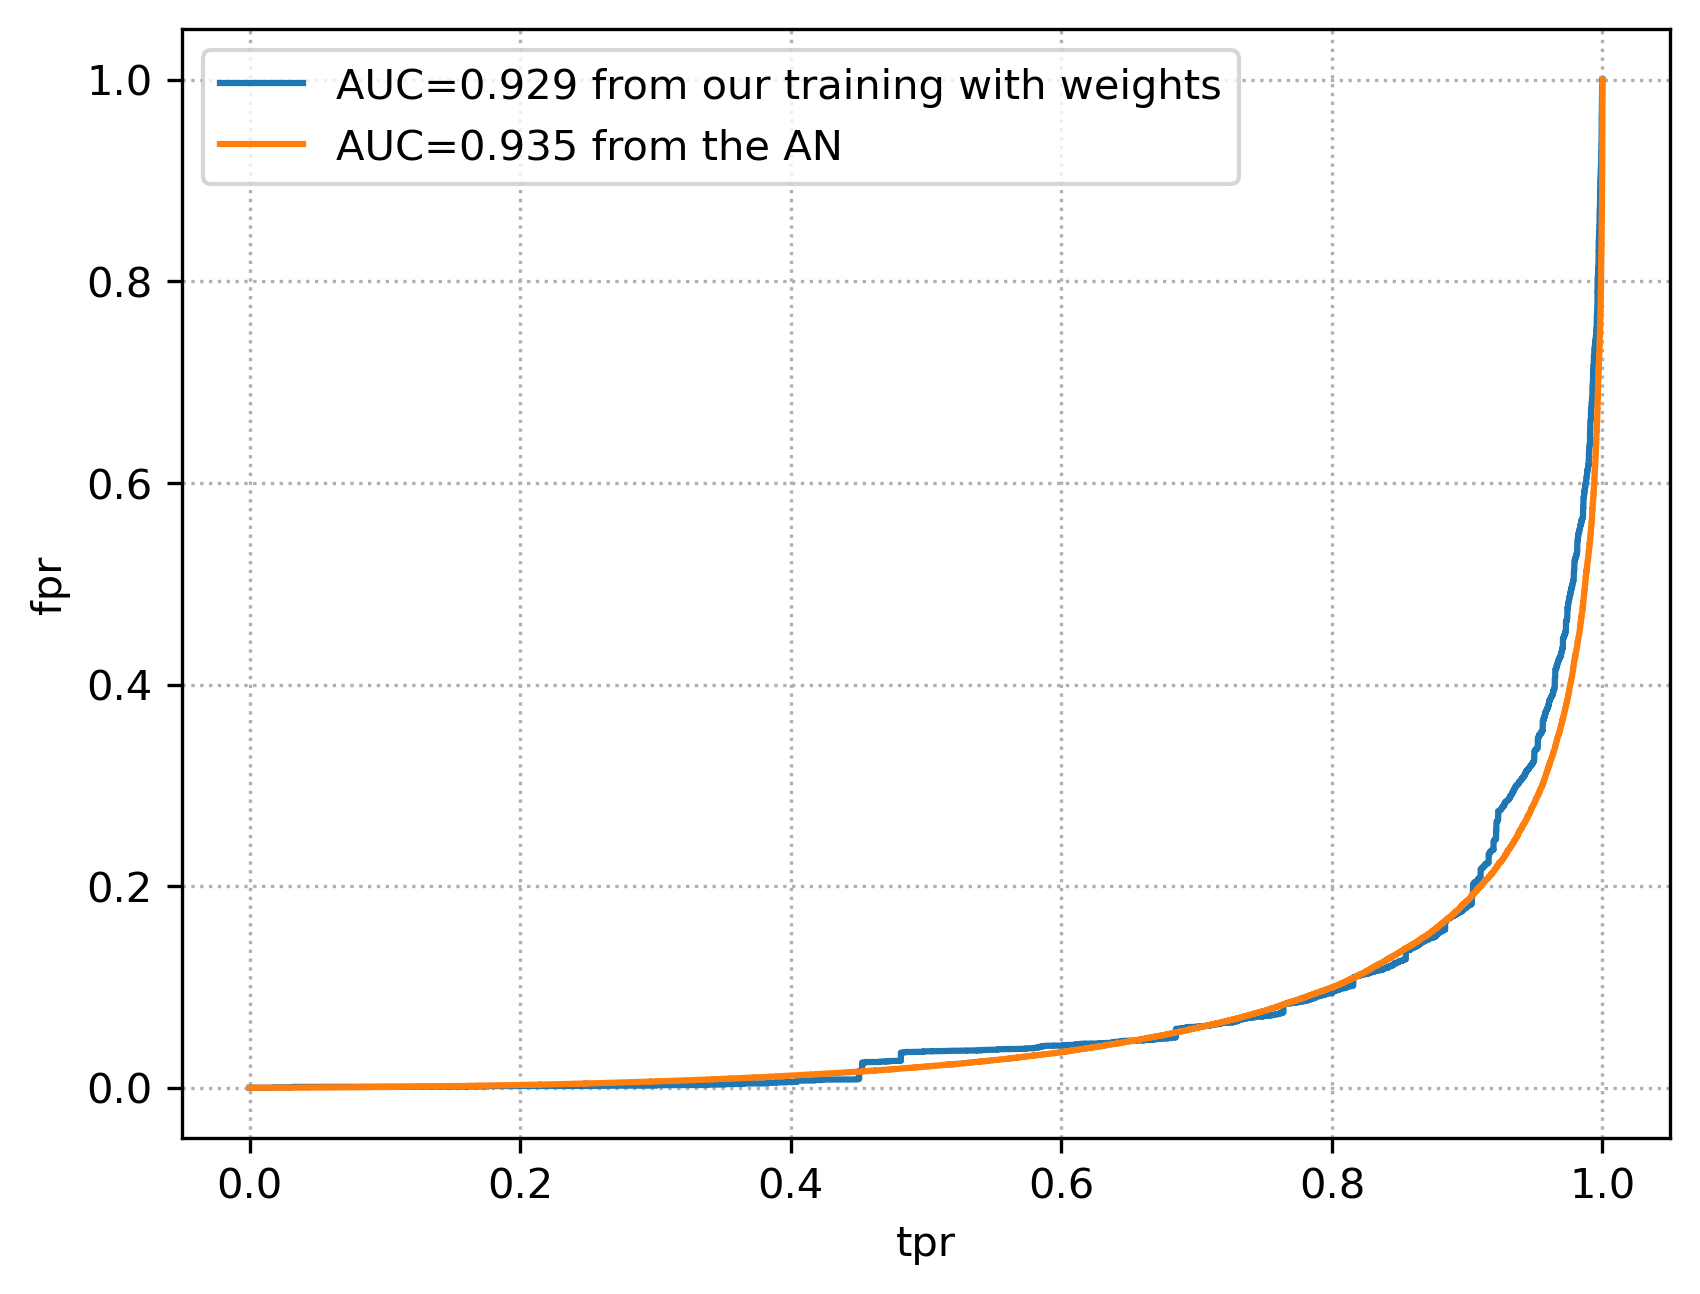

In [ ]:
def roc_curve_plot_comp(test_dataset, dataset_pred):
    true=test_dataset["CLASSIFICATIONS"]["EVENT"]["signal"][()]
    print(true)
    proba_signal=dataset_pred["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()]
    print(proba_signal)
    events=test_dataset["CLASSIFICATIONS"]["EVENT"]["signal"][()]
    bckg_events= test_dataset["CLASSIFICATIONS"]["EVENT"]["signal"][()] ==0
    
    weights= test_dataset["WEIGHTS"]['weight'][()]
    print(weights)
    # weights= np.ones_like(weights)
    
    # class_signal_weight=7.8112e-04
    # class_bckg_weight= 1.9998
    
    # adjusted_weights = [
    # weight * class_signal_weight if label == 1 else weight * class_bckg_weight
    # for weight, label in zip(weights, events)
    # ]
    
    fpr, tpr, thresholds = roc_curve(true, proba_signal, sample_weight=weights)
    fpr_r=df_roc_0[:,0]
    tpr_r=df_roc_0[:,1]
    
    score=roc_auc_score(true, proba_signal, sample_weight=weights)
    score_2=auc(fpr_r, tpr_r)
    print(score)
    
    plt.plot(tpr,fpr,label=f"AUC={score:.3f} from our training with weights")
    plt.plot(tpr_r,fpr_r,label=f"AUC={score_2:.3f} from the AN")
    plt.legend()
    plt.xlabel("tpr")
    # plt.yscale("log")
    plt.ylabel("fpr")
    plt.grid(linestyle=":")
    plt.show()
    
roc_curve_plot_comp(df_test_4b_QCD,df_pred_4v_dnn)

In [ ]:
# print(len(df_test["WEIGHTS"]['weight']))
# print(len(proba_weight))

[1 0 0 ... 1 1 1]
[0.9098841  0.686947   0.13033812 ... 0.84192044 0.82523113 0.9034847 ]
[-4.0341192e-03  6.6404986e-08  1.6274313e-07 ...  4.0341192e-03
  4.0341192e-03  4.0341192e-03]
0.9314861690422742


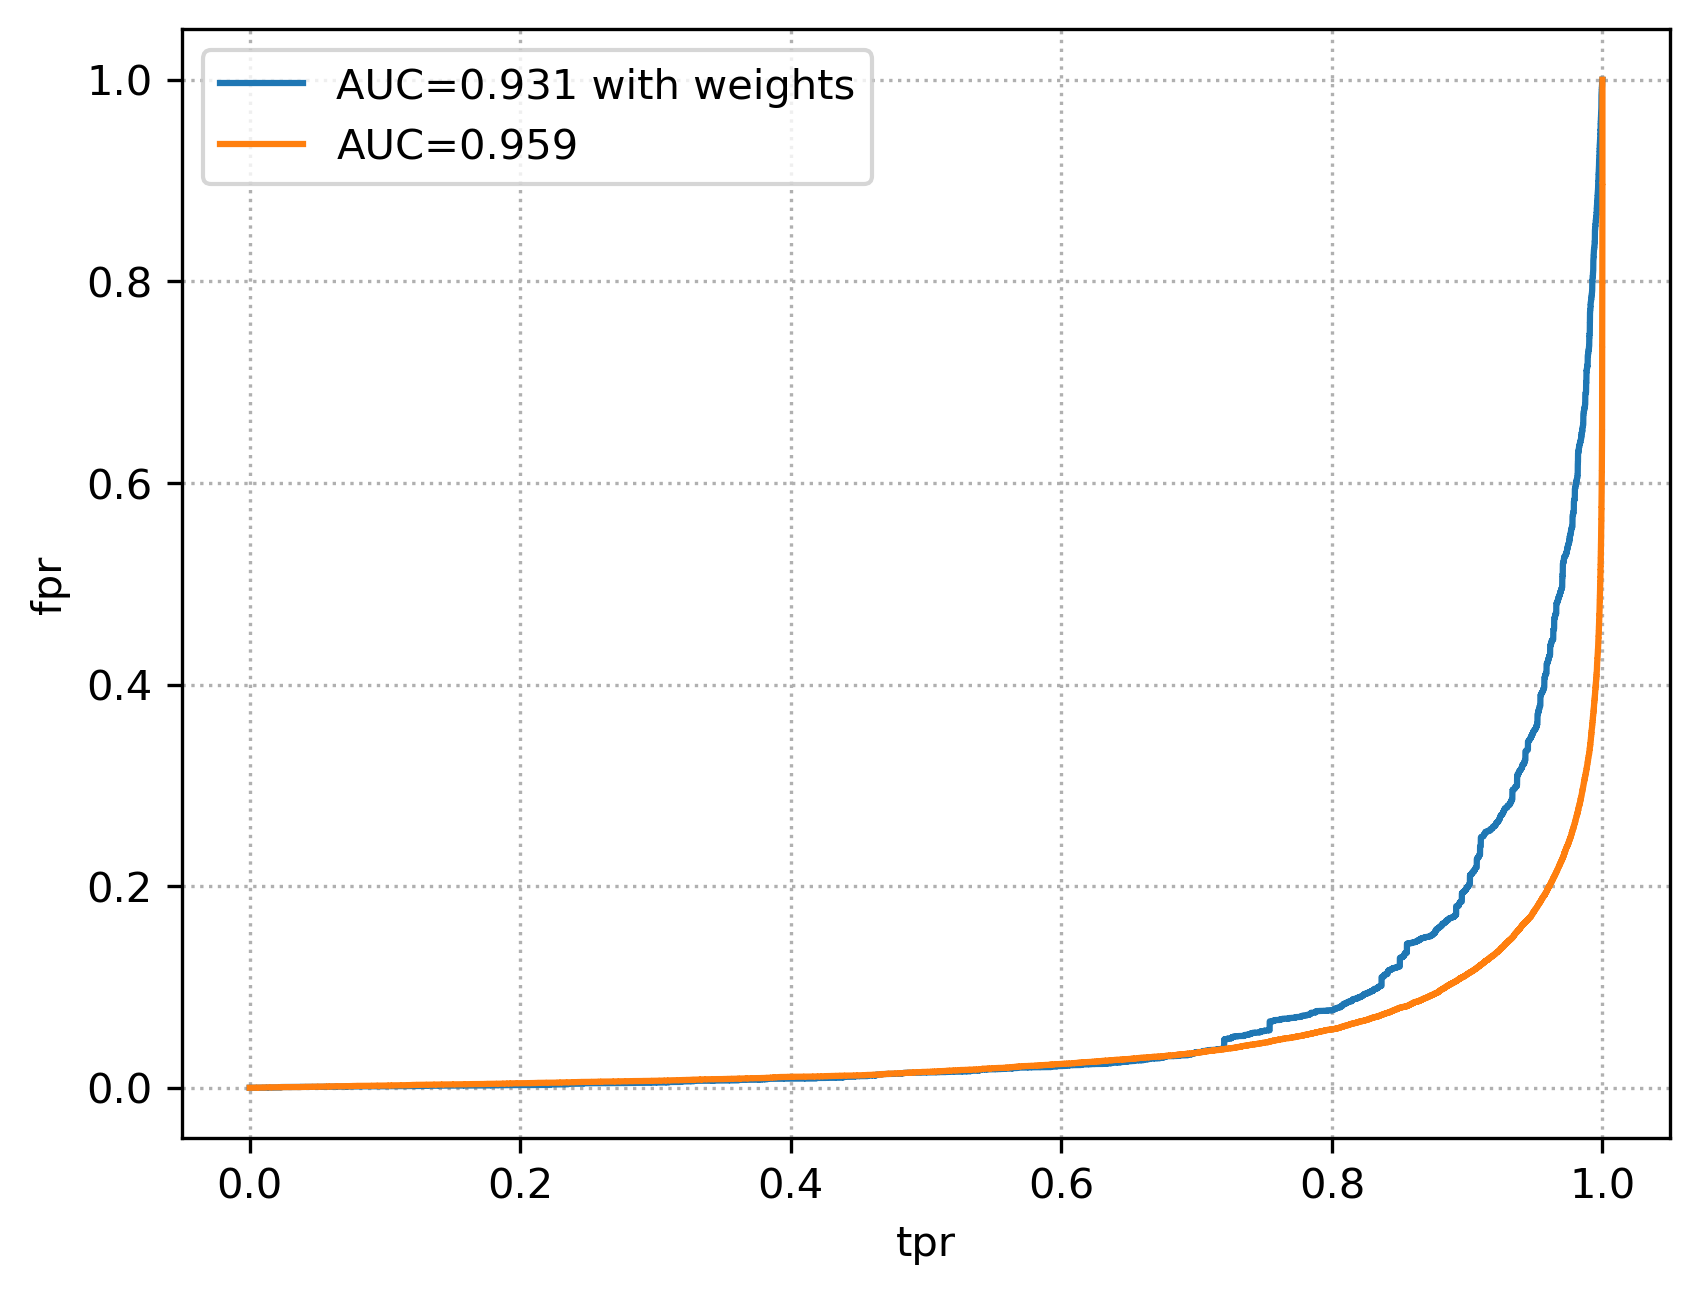

In [5]:
roc_curve_plot(df_test_4b_QCD,df_pred_4b_QCD)


In [ ]:
# def roc_curve_compare_weights(test,list_pred,list_labels):
#     true= test["CLASSIFICATIONS"]["EVENT"]["signal"][()]
#     proba_signal= [pred["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()] for pred in list_pred]
#     print(len(proba_signal))
#     weights= test["WEIGHTS"]['weight'][()]
#     score= [roc_auc_score(true, proba_signal[i], sample_weight=weights) for i in range(len(proba_signal))]
#     print(score)
#     fpr, tpr, thresholds = zip(*[roc_curve(true, proba_signal[i], sample_weight=weights) for i in range(len(proba_signal))])
#     for i in range(len(fpr)):
#         plt.plot(tpr[i],fpr[i],label=f"{list_labels[i]} with AUC={score[i]:.3f}")
#         plt.legend(loc="upper left", fontsize= "small")
#         plt.xlabel("tpr")
#         plt.ylabel("fpr")
#         plt.grid(linestyle=":")
#     plt.show()
    
# roc_curve_compare_weights(df_test_4b_QCD,list_pred, list_labels)

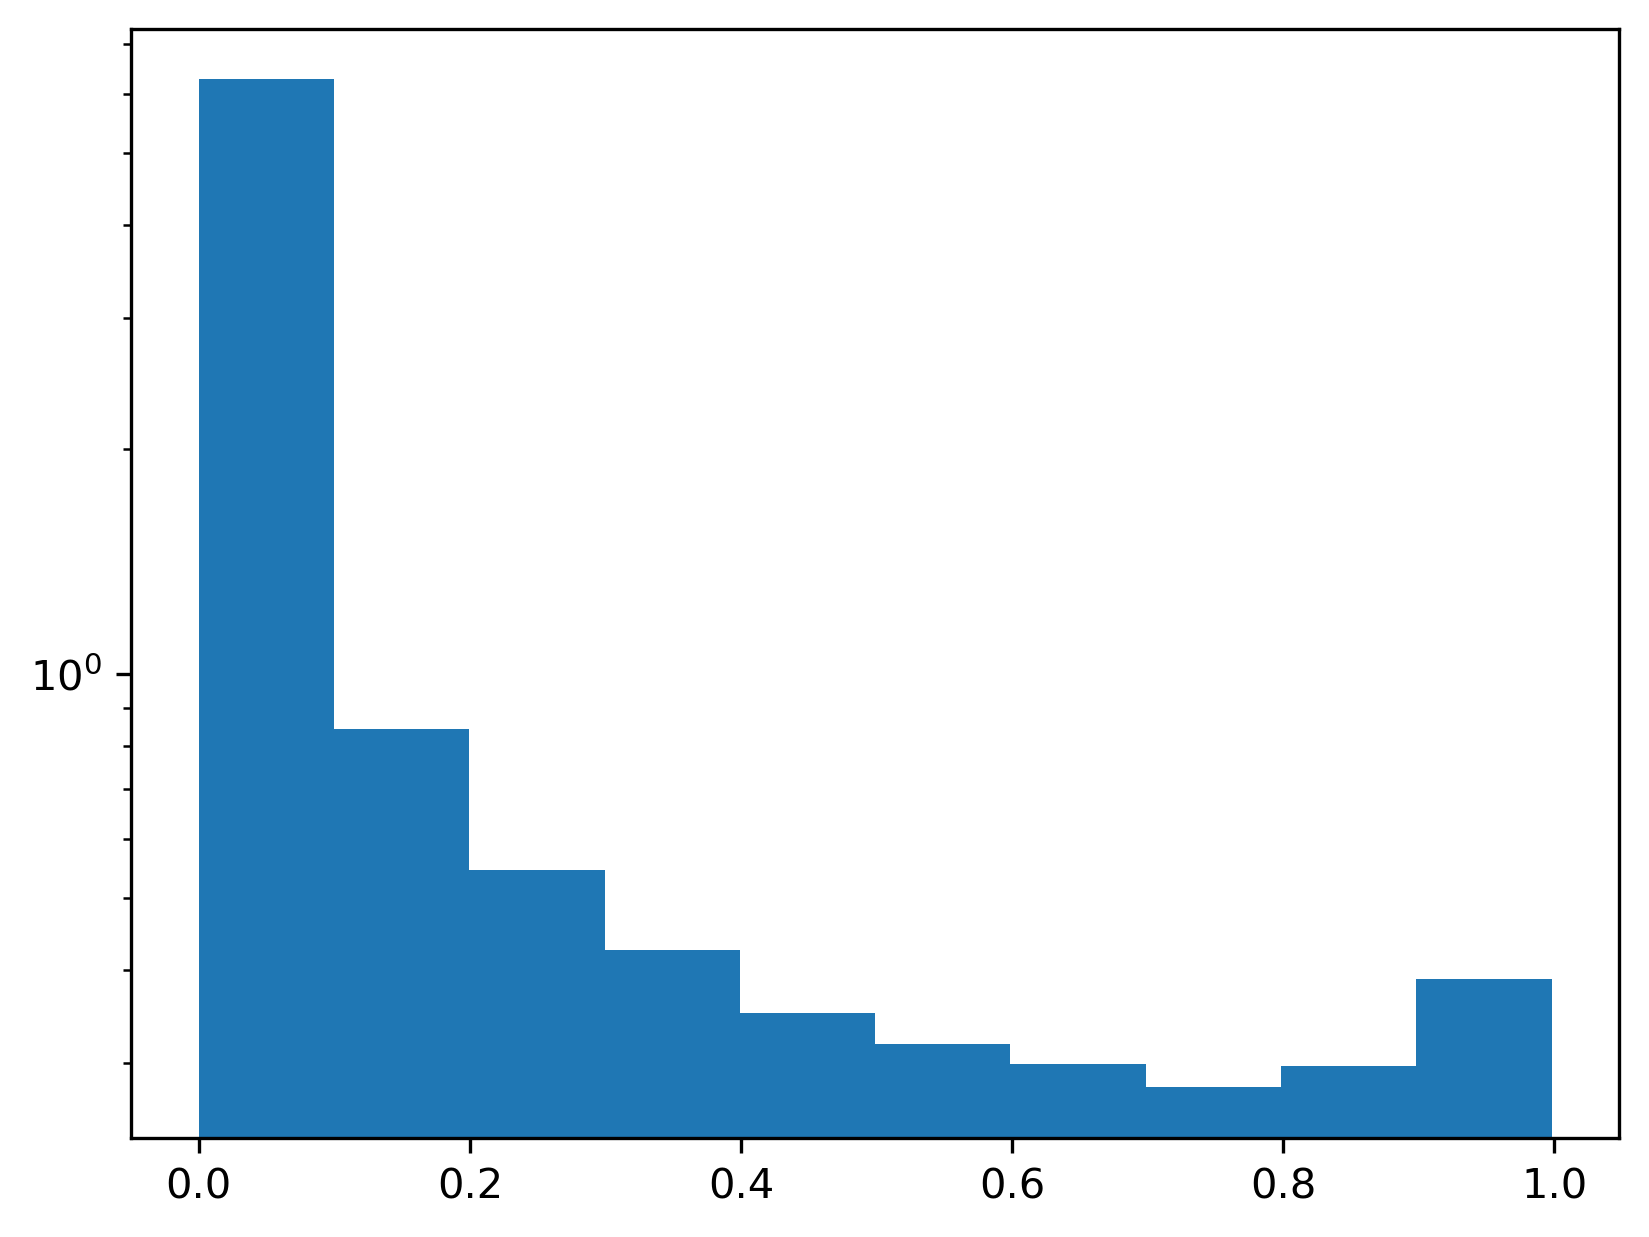

In [ ]:

proba_s=df_pred_2b_QCD["CLASSIFICATIONS"]["EVENT"]["signal"][:,1][()]
mask_b=df_test_2b_QCD["CLASSIFICATIONS"]["EVENT"]["signal"][()] ==0
mask_s=df_test_2b_QCD["CLASSIFICATIONS"]["EVENT"]["signal"][()] ==1

proba_s_s=proba_s[mask_s]
proba_s_b=proba_s[mask_b]

plt.hist(proba_s_b, density=True)
plt.yscale("log")

In [ ]:
# print(fpr)
# print(tpr)
# print(thresholds)

In [ ]:
# np.sum(proba_signal_signal >0.5)/len(proba_signal_signal)

In [ ]:
# np.sum(proba_signal_background >0.5)/len(proba_signal_background)

In [ ]:
# np.argmax(thresholds < 0.5)
# fpr[np.argmax(thresholds < 0.5)]
# tpr[np.argmax(thresholds < 0.5)]

In [ ]:
# targets is a dictiornary with key ['EVENT/signal']
# the class weights are: tensor([1.9998e+00, 2.4529e-04], device='cuda:0')
# the event weights are: event weights tensor([0.0040, 0.0040, 0.0040,  ..., 0.0040, 0.0040, 0.0040], device='cuda:0')

1788+260

2048

In [ ]:
print(0.9995**1.5695e-01)
print(0.9995**2.0250e+03)



0.9999215084553305
0.3632175876043771


## Probabilities difference plots

In [ ]:
def diff_proba_no_weights(dataset_pred,dataset_test , name, title):
    
    mask_signal=dataset_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==1
    mask_background=dataset_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==0
    diff_proba_signal=np.arctanh(dataset_pred["INPUTS"]["Event"]["Probability_difference"][()][mask_signal])
    diff_proba_bckg=np.arctanh(dataset_pred["INPUTS"]["Event"]["Probability_difference"][()][mask_background])
    
    # for the weights we can define the signal and bckg weights that we ten apply to the histogram, respectively for the signal and the background
    # weights_signal= dataset_test["WEIGHTS"]['weight'][()][mask_signal]
    # weights_bckg= dataset_test["WEIGHTS"]['weight'][()][mask_background]
    
    fig = plt.figure()
    plt.hist(diff_proba_signal,bins=40,range=(-1,8),histtype='step',label="Signal", density=True)
    plt.hist(diff_proba_bckg,bins=40,range=(-1,8),histtype='step',label="Background", density=True)
    plt.legend(loc="upper right")
    plt.xlabel(r"arctanh($\Delta$ Probability)")
    plt.yscale("log")
    plt.ylabel("Normalized counts")
    plt.title(f"Probability difference {title}")
    plt.grid(linestyle=":")
    plt.savefig(f"/afs/cern.ch/user/r/ramellar/HH4b_SPANet/probability_difference_plots/probability_difference_plots_no_weights/{name}_no_weights")
    plt.close(fig)
    return diff_proba_signal, diff_proba_bckg

# diff_proba_no_weights(df_train, df_train,"train_dnn_4b_QCD", "for 4b QCD training file")
# diff_proba_no_weights(df_pred_2b_data, df_test_2b_data, "pred_dnn_2b_data", "for 2b data prediction with DNN vars")
# diff_proba_no_weights(df_test_2b_data, df_test_2b_data, "test_dnn_2b_data", "for 2b data test file with DNN vars")
# diff_proba_no_weights(df_pred_2b_QCD, df_test_2b_QCD, "pred_dnn_2b_QCD", "for 2b QCD prediction with DNN vars")
# diff_proba_signal_2b_QCD, diff_proba_bckg_2b_QCD= diff_proba_no_weights(df_test_2b_QCD, df_test_2b_QCD, "test_dnn_2b_QCD", "for 2b QCD test file with DNN vars")
# diff_proba_no_weights(df_test_old_model, df_test_old_model,"old_model_test_dnn_2b_QCD", "for 4b QCD produced with the old SPANET model")
# diff_proba_no_weights(df_pred_4v_dnn, df_test_old_model, "pred_dnn_4b_QCD", "for 4b QCD prediction with DNN variables")
# diff_proba_no_weights(df_pred_4v_proba_dnn,df_test_4b_QCD, "pred_proba_dnn_4b_QCD", "for 4b QCD prediction with probability difference and DNN variables")
# diff_proba_no_weights(df_test_4b_QCD, df_test_4b_QCD, "test_4b_QCD", "for 4b QCD test file")

diff_proba_no_weights

/tmp/ramellar/ipykernel_1622257/567416256.py:5: RuntimeWarning: divide by zero encountered in arctanh
  diff_proba_signal=np.arctanh(dataset_pred["INPUTS"]["Event"]["Probability_difference"][()][mask_signal])
/tmp/ramellar/ipykernel_1622257/567416256.py:6: RuntimeWarning: divide by zero encountered in arctanh
  diff_proba_bckg=np.arctanh(dataset_pred["INPUTS"]["Event"]["Probability_difference"][()][mask_background])
/tmp/ramellar/ipykernel_1622257/567416256.py:5: RuntimeWarning: divide by zero encountered in arctanh
  diff_proba_signal=np.arctanh(dataset_pred["INPUTS"]["Event"]["Probability_difference"][()][mask_signal])
/tmp/ramellar/ipykernel_1622257/567416256.py:5: RuntimeWarning: divide by zero encountered in arctanh
  diff_proba_signal=np.arctanh(dataset_pred["INPUTS"]["Event"]["Probability_difference"][()][mask_signal])
/tmp/ramellar/ipykernel_1622257/567416256.py:5: RuntimeWarning: divide by zero encountered in arctanh
  diff_proba_signal=np.arctanh(dataset_pred["INPUTS"]["Event

(array([4.8452096, 3.5335948, 1.9222978, ..., 3.228215 , 1.3504517,
        2.0612886], dtype=float32),
 array([2.2303193 , 0.9621895 , 1.3842597 , ..., 0.55070853, 1.553316  ,
        1.626318  ], dtype=float32))

In [ ]:
diff_proba_signal_2b_QCD, diff_proba_bckg_2b_QCD= diff_proba_no_weights(df_test_2b_QCD, df_test_2b_QCD, "test_dnn_2b_QCD", "for 2b QCD test file with DNN vars")


In [ ]:
def diff_proba_weights(dataset_pred,dataset_test , name, title):
    
    mask_signal=dataset_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==1
    mask_background=dataset_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==0
    diff_proba_signal=(dataset_pred["INPUTS"]["Event"]["Probability_difference"][()][mask_signal])
    diff_proba_bckg=(dataset_pred["INPUTS"]["Event"]["Probability_difference"][()][mask_background])
    
    # for the weights we can define the signal and bckg weights that we then apply to the histogram, respectively for the signal and the background
    weights_signal= dataset_test["WEIGHTS"]['weight'][()][mask_signal]
    weights_bckg= dataset_test["WEIGHTS"]['weight'][()][mask_background]
    
    fig = plt.figure()
    plt.hist(diff_proba_signal,bins=40,range=(-1,8),histtype='step',label="Signal weighted", density=True, weights=weights_signal)
    plt.hist(diff_proba_bckg,bins=40,range=(-1,8),histtype='step',label="Background weighted", density=True, weights=weights_bckg)
    plt.hist(diff_proba_signal,bins=40,range=(-1,8),histtype='step',label="Signal", density=True)
    plt.hist(diff_proba_bckg,bins=40,range=(-1,8),histtype='step',label="Background", density=True)
    plt.legend(loc="upper right")
    plt.xlabel(r"arctanh($\Delta$ Probability)")
    plt.yscale("log")
    plt.ylabel("Normalized counts")
    plt.title(f"Probability difference {title}")
    plt.grid(linestyle=":")
    plt.savefig(f"/afs/cern.ch/user/r/ramellar/HH4b_SPANet/probability_difference_plots/probability_difference_plots_weights/{name}_weights")
    plt.close(fig)
    return diff_proba_signal, diff_proba_bckg

diff_proba_weights(df_train, df_train,"train_dnn_4b_QCD_comp_arctanh", "for 4b QCD training file")
diff_proba_weights(df_pred_2b_data, df_test_2b_data, "pred_dnn_2b_data_comp_arctanh", "for 2b data prediction with DNN vars")
diff_proba_weights(df_test_2b_data, df_test_2b_data, "test_dnn_2b_data_comp_arctanh", "for 2b data test file with DNN vars")
diff_proba_weights(df_pred_2b_QCD, df_test_2b_QCD, "pred_dnn_2b_QCD_comp_arctanh", "for 2b QCD prediction with DNN vars")
diff_proba_weights(df_test_2b_QCD, df_test_2b_QCD, "test_dnn_2b_QCD_comp_arctanh", "for 2b QCD test file with DNN vars")
diff_proba_weights(df_test_old_model, df_test_old_model,"old_model_test_dnn_2b_QCD_comp_arctanh", "for 4b QCD produced with the old SPANET model")
diff_proba_weights(df_pred_4v_dnn, df_test_old_model, "pred_dnn_4b_QCD_comp_arctanh", "for 4b QCD prediction with DNN variables")
diff_proba_weights(df_pred_4v_proba_dnn,df_test_4b_QCD, "pred_proba_dnn_4b_QCD_comp_arctanh", "for 4b QCD prediction with probability difference and DNN variables")
diff_proba_weights(df_test_4b_QCD, df_test_4b_QCD, "test_4b_QCD_comp_arctanh", "for 4b QCD test file")

(array([0.99987626, 0.9982962 , 0.9581062 , ..., 0.99686414, 0.8741599 ,
        0.9681113 ], dtype=float32),
 array([0.977154  , 0.7452519 , 0.88190156, ..., 0.50105107, 0.91433096,
        0.92553544], dtype=float32))

In [ ]:
def diff_proba_weights_comparison(dataset_pred,dataset_test , name, title):
    
    mask_signal=dataset_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==1
    mask_background=dataset_test["CLASSIFICATIONS"]["EVENT"]["signal"][()]==0
    diff_proba_signal=(dataset_pred["INPUTS"]["Event"]["Probability_difference"][()][mask_signal])
    diff_proba_bckg=(dataset_pred["INPUTS"]["Event"]["Probability_difference"][()][mask_background])
    
    # for the weights we can define the signal and bckg weights that we ten apply to the histogram, respectively for the signal and the background
    weights_signal= dataset_test["WEIGHTS"]['weight'][()][mask_signal]
    weights_bckg= dataset_test["WEIGHTS"]['weight'][()][mask_background]
    print("weights_bckg", weights_bckg)
    
    fig = plt.figure()
    plt.hist(diff_proba_signal,bins=40,range=(-0.25,1.1),histtype='step',label="Signal", density=True)
    plt.hist(diff_proba_bckg,bins=40,range=(-0.25,1.1),histtype='step',label="Background", density=True)
    plt.hist(diff_proba_signal,bins=40,range=(-0.25,1.1),histtype='step',label="Signal weighted", density=True, weights=weights_signal)
    plt.hist(diff_proba_bckg,bins=40,range=(-0.25,1.1),histtype='step',label="Background weighted", density=True, weights=weights_bckg)
    plt.legend(loc='upper right', fontsize="x-small")
    plt.xlabel(r"$\Delta$ Probability")
    plt.yscale("log")
    plt.ylabel("Normalized counts")
    plt.title(f"Probability difference {title}")
    plt.grid(linestyle=":")
    plt.savefig(f"/afs/cern.ch/user/r/ramellar/HH4b_SPANet/probability_difference_plots/probability_difference_plots_weights_comparison_w_now/{name}")
    plt.close(fig)
    return diff_proba_signal, diff_proba_bckg

# diff_proba_weights_comparison(df_train, df_train,"train_dnn_4b_QCD_noarc", "for 4b QCD training file")
# diff_proba_weights_comparison(df_pred_2b_data, df_test_2b_data, "pred_dnn_2b_data", "for 2b data prediction with DNN vars")
# diff_proba_weights_comparison(df_test_2b_data, df_test_2b_data, "test_dnn_2b_data", "for 2b data test file with DNN vars")
# diff_proba_weights_comparison(df_pred_2b_QCD, df_test_2b_QCD, "pred_dnn_2b_QCD", "for 2b QCD prediction with DNN vars")
# diff_proba_weights_comparison(df_test_2b_QCD, df_test_2b_QCD, "test_dnn_2b_QCD", "for 2b QCD test file with DNN vars")
# diff_proba_weights_comparison(df_test_old_model, df_test_old_model,"old_model_test_dnn_2b_QCD_noarc", "for 4b QCD produced with the old SPANET model")
# diff_proba_weights_comparison(df_pred_4v_dnn, df_test_old_model, "pred_dnn_4b_QCD_noarc", "for 4b QCD prediction with DNN variables")
# diff_proba_weights_comparison(df_pred_4v_proba_dnn, df_test_4b_QCD, "pred_proba_dnn_4b_QCD_noarc", "for 4b QCD prediction with probability difference and DNN variables")
# diff_proba_weights_comparison(df_test_4b_QCD, df_test_4b_QCD, "test_4b_QCD_noarc", "for 4b QCD test file")

In [ ]:
diff_proba_weights_comparison(df_pred_2b_QCD, df_test_2b_QCD, "pred_dnn_2b_QCD_noarc", "for 2b QCD prediction with DNN vars")
diff_proba_weights_comparison(df_pred_2b_data, df_test_2b_data, "pred_dnn_2b_data_noarc", "for 2b data prediction with DNN vars")
diff_proba_weights_comparison(df_pred_4v_proba_dnn, df_test_4b_QCD, "pred_proba_dnn_4b_QCD_noarc", "for 4b QCD prediction with probability difference and DNN variables")


weights_bckg [2.5648554e-08 4.9550413e-09 6.7160315e-08 ... 2.5605189e-08 2.5838952e-08
 1.6260273e-07]
weights_bckg [1.6909745e-07 1.6909745e-07 1.6909745e-07 ... 1.6909745e-07 1.6909745e-07
 1.6909745e-07]
weights_bckg [6.5741240e-08 2.5473813e-08 6.6251843e-08 ... 6.0745452e-07 1.6130312e-07
 4.8039119e-09]


(array([0.99987626, 0.9982962 , 0.9581062 , ..., 0.99686414, 0.8741599 ,
        0.9681113 ], dtype=float32),
 array([0.977154  , 0.7452519 , 0.88190156, ..., 0.50105107, 0.91433096,
        0.92553544], dtype=float32))

## ROC curves for probability difference

In [ ]:
def roc_curve_proba_diff_no_weights(dataset_pred, test_dataset, name, title):
    true=test_dataset["CLASSIFICATIONS"]["EVENT"]["signal"][()]
    diff_proba= dataset_pred["INPUTS"]["Event"]["Probability_difference"][()]
    
    fpr, tpr, thresholds = roc_curve(true, diff_proba)
    score=roc_auc_score(true, diff_proba)

    fig = plt.figure()
    plt.plot(tpr,fpr,label=f"AUC={score:.3f}")
    # plt.plot(tpr_r,fpr_r,label=f"AUC={score_2:.3f} from the AN")
    plt.legend()
    plt.xlabel("tpr")
    # plt.yscale("log")
    plt.ylabel("fpr")
    plt.title(f"Probability difference ROC curve {title}", fontsize= 'small')
    plt.grid(linestyle=":")
    plt.savefig(f"/afs/cern.ch/user/r/ramellar/HH4b_SPANet/probability_difference_plots/ROC_curves_no_weights/{name}_no_weights")
    plt.close(fig)
    plt.show()


roc_curve_proba_diff_no_weights(df_train, df_train,"train_dnn_4b_QCD", "for 4b QCD training file")
roc_curve_proba_diff_no_weights(df_pred_2b_data, df_test_2b_data, "pred_dnn_2b_data", "for 2b data prediction with DNN vars")
roc_curve_proba_diff_no_weights(df_test_2b_data, df_test_2b_data, "test_dnn_2b_data", "for 2b data test file with DNN vars")
roc_curve_proba_diff_no_weights(df_pred_2b_QCD, df_test_2b_QCD, "pred_dnn_2b_QCD", "for 2b QCD prediction with DNN vars")
roc_curve_proba_diff_no_weights(df_test_2b_QCD, df_test_2b_QCD, "test_dnn_2b_QCD", "for 2b QCD test file with DNN vars")
roc_curve_proba_diff_no_weights(df_test_old_model, df_test_old_model,"old_model_test_dnn_2b_QCD", "for 4b QCD produced with the old SPANET model")
roc_curve_proba_diff_no_weights(df_pred_4v_dnn, df_test_old_model, "pred_dnn_4b_QCD", "for 4b QCD prediction with DNN variables")
roc_curve_proba_diff_no_weights(df_pred_4v_proba_dnn,df_test_4b_QCD, "pred_proba_dnn_4b_QCD", "for 4b QCD prediction with probability difference and DNN variables")
roc_curve_proba_diff_no_weights(df_test_4b_QCD, df_test_4b_QCD, "test_4b_QCD", "for 4b QCD test file")

In [ ]:
def roc_curve_proba_diff_weights(dataset_pred, test_dataset, name, title):
    true=test_dataset["CLASSIFICATIONS"]["EVENT"]["signal"][()]
    diff_proba= dataset_pred["INPUTS"]["Event"]["Probability_difference"][()]
    
    weights= test_dataset["WEIGHTS"]['weight'][()]
    fpr, tpr, thresholds = roc_curve(true, diff_proba, sample_weight= weights)
    score=roc_auc_score(true, diff_proba, sample_weight= weights)

    fig = plt.figure()
    plt.plot(tpr,fpr,label=f"AUC={score:.3f}")
    plt.legend()
    plt.xlabel("tpr")
    plt.ylabel("fpr")
    plt.title(f"Probability difference weighted ROC curve {title}", fontsize= 'small')
    plt.grid(linestyle=":")
    plt.savefig(f"/afs/cern.ch/user/r/ramellar/HH4b_SPANet/probability_difference_plots/ROC_curves_weights/{name}_weights")
    plt.close(fig)
    plt.show()


roc_curve_proba_diff_weights(df_train, df_train,"train_dnn_4b_QCD", "for 4b QCD training file")
roc_curve_proba_diff_weights(df_pred_2b_data, df_test_2b_data, "pred_dnn_2b_data", "for 2b data prediction with DNN vars")
roc_curve_proba_diff_weights(df_test_2b_data, df_test_2b_data, "test_dnn_2b_data", "for 2b data test file with DNN vars")
roc_curve_proba_diff_weights(df_pred_2b_QCD, df_test_2b_QCD, "pred_dnn_2b_QCD", "for 2b QCD prediction with DNN vars")
roc_curve_proba_diff_weights(df_test_2b_QCD, df_test_2b_QCD, "test_dnn_2b_QCD", "for 2b QCD test file with DNN vars")
roc_curve_proba_diff_weights(df_test_old_model, df_test_old_model,"old_model_test_dnn_2b_QCD", "for 4b QCD produced with the old SPANET model")
roc_curve_proba_diff_weights(df_pred_4v_dnn, df_test_old_model, "pred_dnn_4b_QCD", "for 4b QCD prediction with DNN variables")
roc_curve_proba_diff_weights(df_pred_4v_proba_dnn, df_test_4b_QCD, "pred_proba_dnn_4b_QCD", "for 4b QCD prediction with probability difference and DNN variables")
roc_curve_proba_diff_weights(df_test_4b_QCD, df_test_4b_QCD, "test_4b_QCD", "for 4b QCD test file")

In [ ]:
def roc_curve_compare_no_weights_prob_diff(list_test,list_pred,list_labels, name):
    # true= test["CLASSIFICATIONS"]["EVENT"]["signal"][()]
    diff_proba= [pred["INPUTS"]["Event"]["Probability_difference"][()] for pred in list_pred]
    true= [t["CLASSIFICATIONS"]["EVENT"]["signal"][()] for t in list_test]
    print((true))
    print( len (diff_proba))
    
    print(true[0].dtype)
    print(diff_proba[0].dtype)
    
    # weights= test["WEIGHTS"]['weight'][()]
    score=roc_auc_score(true[0], diff_proba[0])
    score=[roc_auc_score(true[i], diff_proba[i]) for i in range(len(diff_proba))]
    fpr, tpr, thresholds = zip(*[roc_curve(true[i], diff_proba[i]) for i in range(len(diff_proba))])
    fig= plt.figure()
    for i in range(len(fpr)):
        plt.plot(tpr[i],fpr[i],label=f"{list_labels[i]} with AUC={score[i]:.3f}")
        plt.legend(loc="upper left", fontsize= "small")
        plt.xlabel("tpr")
        plt.ylabel("fpr")
        plt.title("Probability difference ROC curves")
        plt.grid(linestyle=":")
    plt.savefig(f"/afs/cern.ch/user/r/ramellar/HH4b_SPANet/probability_difference_plots/ROC_comparisons/comparison_{name}_no_weights")
    plt.close(fig)
    
list_test=[df_test_4b_QCD, df_test_2b_QCD, df_test_2b_data]
list_pred= [df_pred_4v_dnn, df_pred_2b_QCD, df_pred_2b_data]
list_labels= ["4b QCD DNN vars", "2b QCD DNN vars" , "4b data DNN vars"]

roc_curve_compare_no_weights_prob_diff(list_test,list_pred,list_labels,"dnn_vars")

[array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([0, 1, 1, ..., 1, 1, 1])]
3
int64
float32


In [ ]:
def roc_curve_compare_no_weights_prob_diff(list_test,list_pred,list_labels, name):
    # true= test["CLASSIFICATIONS"]["EVENT"]["signal"][()]
    diff_proba= [pred["INPUTS"]["Event"]["Probability_difference"][()] for pred in list_pred]
    true= [t["CLASSIFICATIONS"]["EVENT"]["signal"][()] for t in list_test]
    print((true))
    print( len (diff_proba))
    
    print(true[0].dtype)
    print(diff_proba[0].dtype)
    
    weights= [t["WEIGHTS"]['weight'][()] for t in list_test]
    score=roc_auc_score(true[0], diff_proba[0])
    score=[roc_auc_score(true[i], diff_proba[i], sample_weight= weights[i]) for i in range(len(diff_proba))]
    fpr, tpr, thresholds = zip(*[roc_curve(true[i], diff_proba[i], sample_weight= weights[i]) for i in range(len(diff_proba))])
    fig= plt.figure()
    for i in range(len(fpr)):
        plt.plot(tpr[i],fpr[i],label=f"{list_labels[i]} with AUC={score[i]:.3f}")
        plt.legend(loc="upper left", fontsize= "small")
        plt.xlabel("tpr")
        plt.ylabel("fpr")
        plt.title("Probability difference ROC curves")
        plt.grid(linestyle=":")
    plt.savefig(f"/afs/cern.ch/user/r/ramellar/HH4b_SPANet/probability_difference_plots/ROC_comparisons/comparison_{name}_weights")
    plt.close(fig)
    
list_test=[df_test_4b_QCD, df_test_2b_QCD, df_test_2b_data]
list_pred= [df_pred_4v_dnn, df_pred_2b_QCD, df_pred_2b_data]
list_labels= ["4b QCD DNN vars", "2b QCD DNN vars" , "4b data DNN vars"]

roc_curve_compare_no_weights_prob_diff(list_test,list_pred,list_labels,"dnn_vars")

[array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([0, 1, 1, ..., 1, 1, 1])]
3
int64
float32


4) probability difference histo-> zoom at 0
5) zoom on the fpr and tpr in the 0.8-1 area

weights_bckg [1.6909745e-07 1.6909745e-07 1.6909745e-07 ... 1.6909745e-07 1.6909745e-07
 1.6909745e-07]


<function matplotlib.pyplot.show(close=None, block=None)>

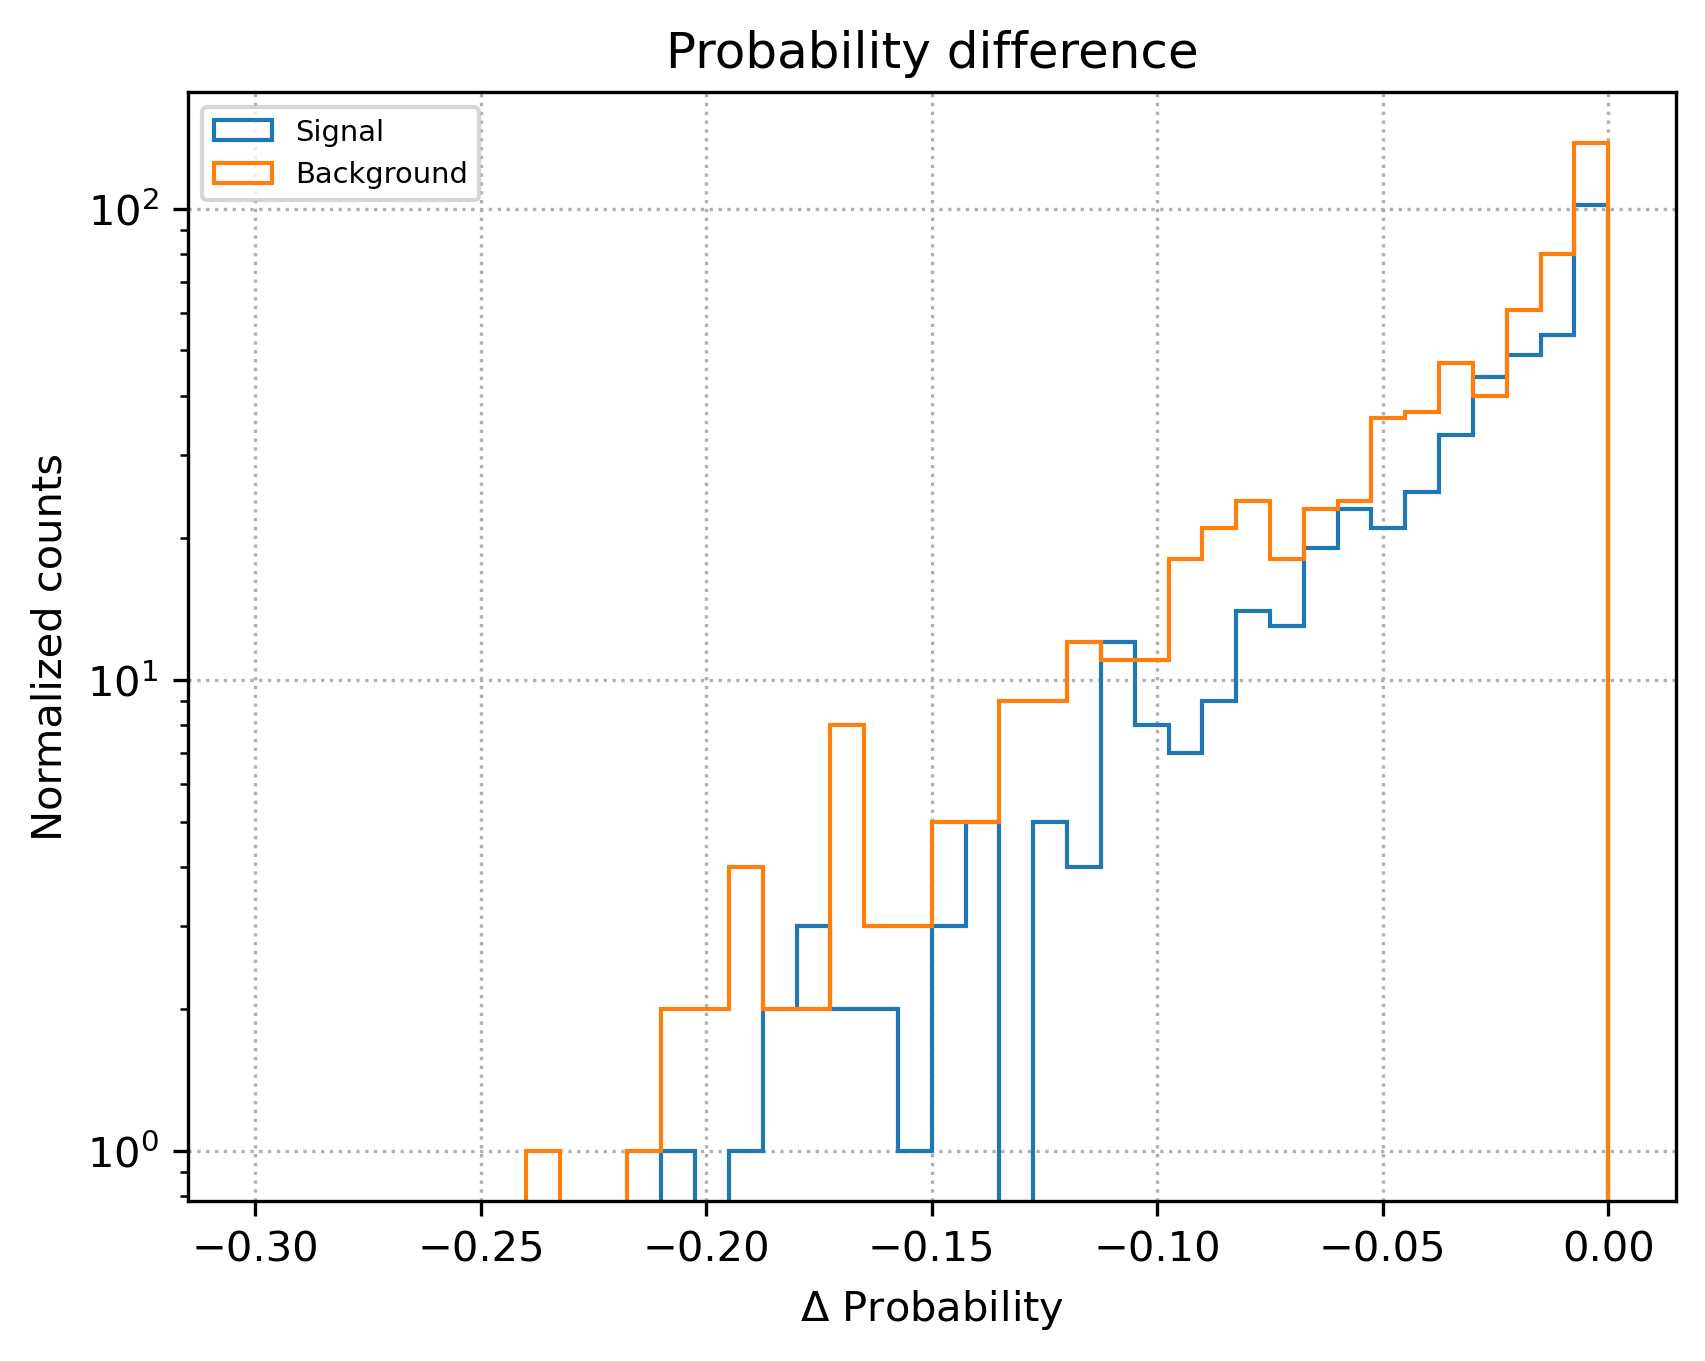

In [ ]:
mask_signal=df_test_2b_data["CLASSIFICATIONS"]["EVENT"]["signal"][()]==1
mask_background=df_test_2b_data["CLASSIFICATIONS"]["EVENT"]["signal"][()]==0
diff_proba_signal=(df_pred_2b_data_proba_dnn["INPUTS"]["Event"]["Probability_difference"][()][mask_signal])
diff_proba_bckg=(df_pred_2b_data_proba_dnn["INPUTS"]["Event"]["Probability_difference"][()][mask_background])

# for the weights we can define the signal and bckg weights that we ten apply to the histogram, respectively for the signal and the background
weights_signal= df_test_2b_data["WEIGHTS"]['weight'][()][mask_signal]
weights_bckg= df_test_2b_data["WEIGHTS"]['weight'][()][mask_background]
print("weights_bckg", weights_bckg)

plt.hist(diff_proba_signal,bins=40,range=(-0.3,0),histtype='step',label="Signal")
plt.hist(diff_proba_bckg,bins=40,range=(-0.3,0),histtype='step',label="Background")
# plt.hist(diff_proba_signal,bins=40,range=(-0.3,0),histtype='step',label="Signal weighted", density=True, weights=weights_signal)
# plt.hist(diff_proba_bckg,bins=40,range=(-0.3,0),histtype='step',label="Background weighted", density=True, weights=weights_bckg)
plt.legend(loc='upper left', fontsize="x-small")
plt.xlabel(r"$\Delta$ Probability")
plt.yscale("log")
plt.ylabel("Normalized counts")
plt.title(f"Probability difference")
plt.grid(linestyle=":")
plt.show

[        inf  1.          0.9999999  ... -0.19044423 -0.20600215
 -0.20821238]
22514


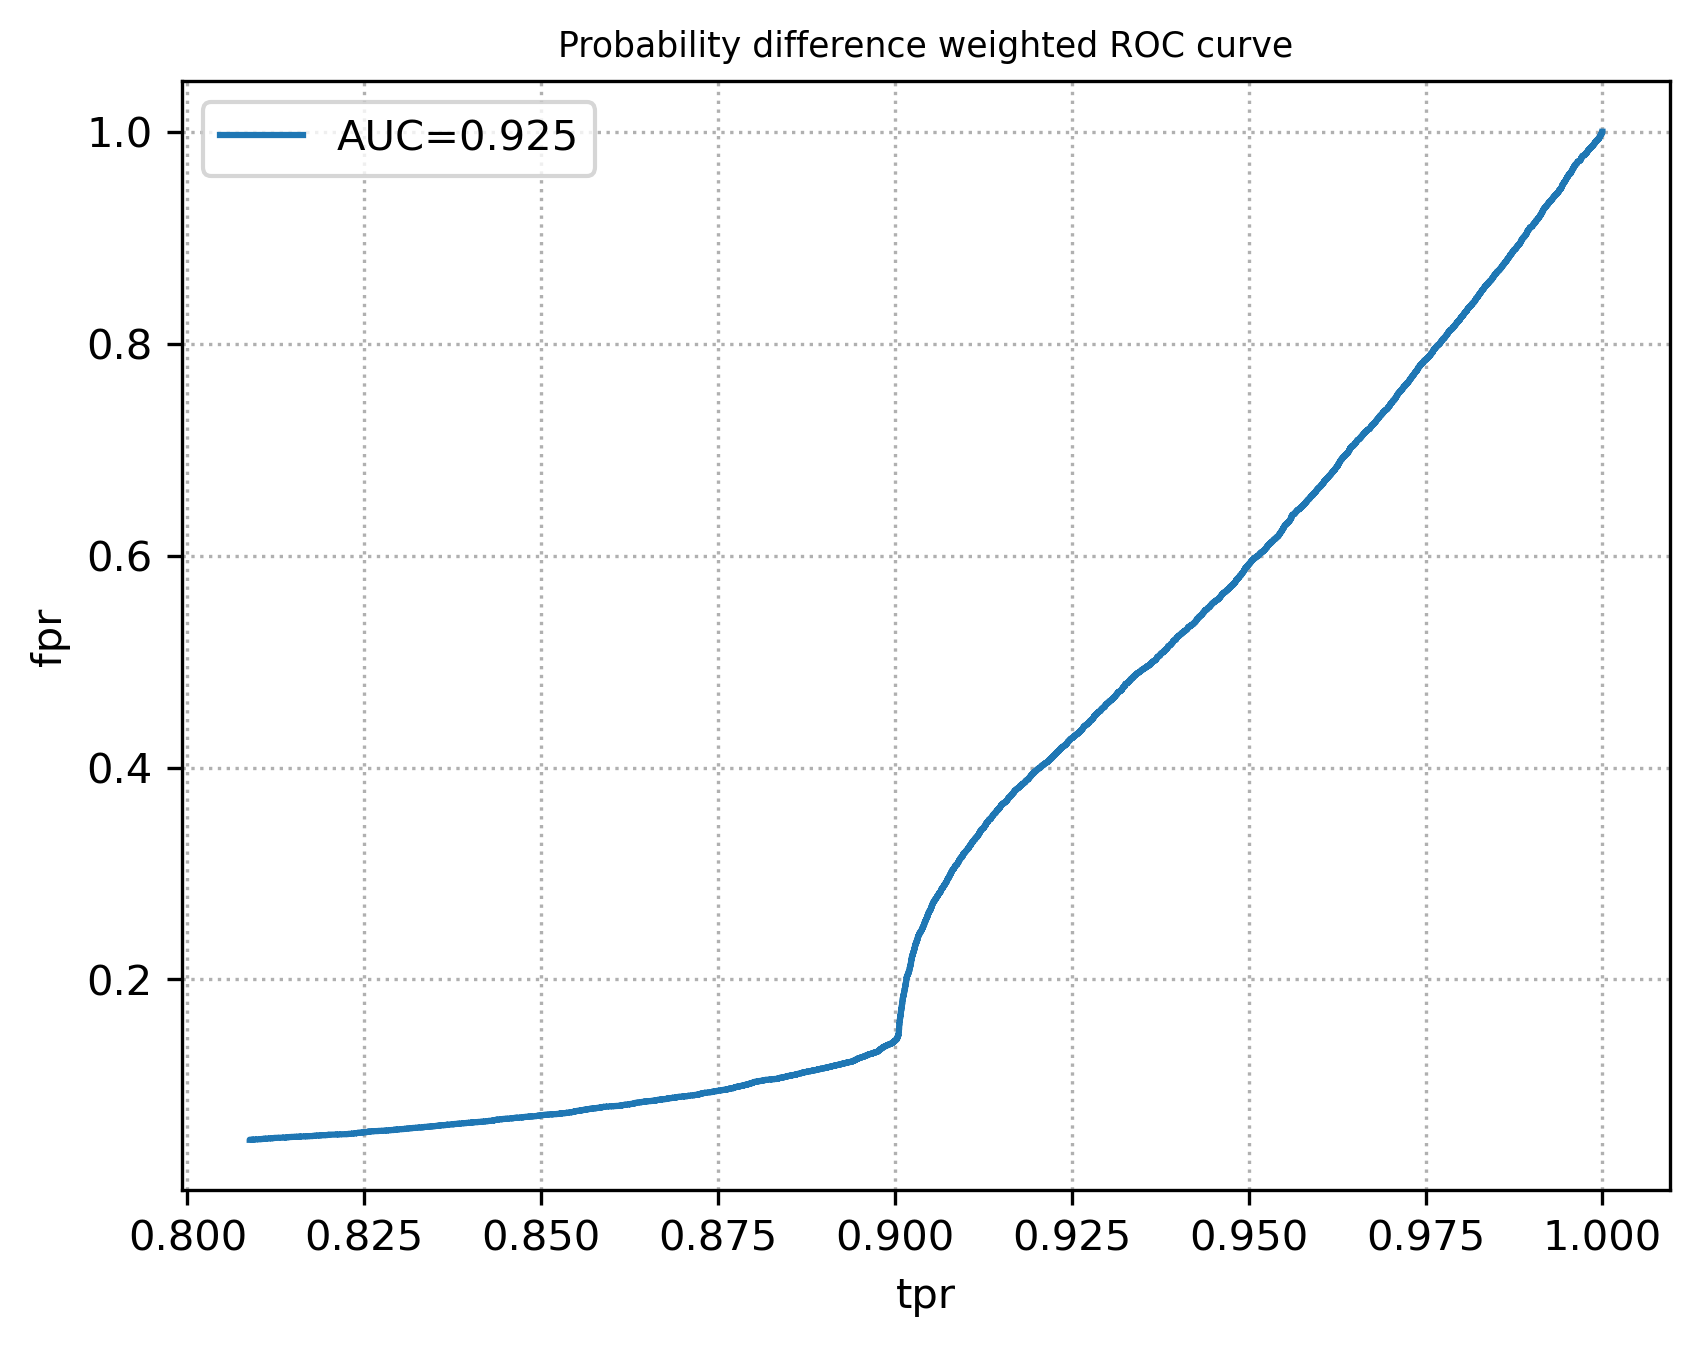

In [ ]:
true=df_test_2b_data["CLASSIFICATIONS"]["EVENT"]["signal"][()]
diff_proba= df_pred_2b_data_proba_dnn["INPUTS"]["Event"]["Probability_difference"][()]

weights= df_test_2b_data["WEIGHTS"]['weight'][()]
fpr, tpr, thresholds = roc_curve(true, diff_proba, sample_weight= weights)
score=roc_auc_score(true, diff_proba, sample_weight= weights)
print(thresholds[:-1])
print(sum(thresholds<0.8))

plt.plot(tpr[thresholds<0.8],fpr[thresholds<0.8],label=f"AUC={score:.3f}")
plt.legend()
plt.xlabel("tpr")
plt.ylabel("fpr")
plt.title(f"Probability difference weighted ROC curve", fontsize= 'small')
plt.grid(linestyle=":")
plt.show()

1.0
1
1.4666841495574856e-05
0.0


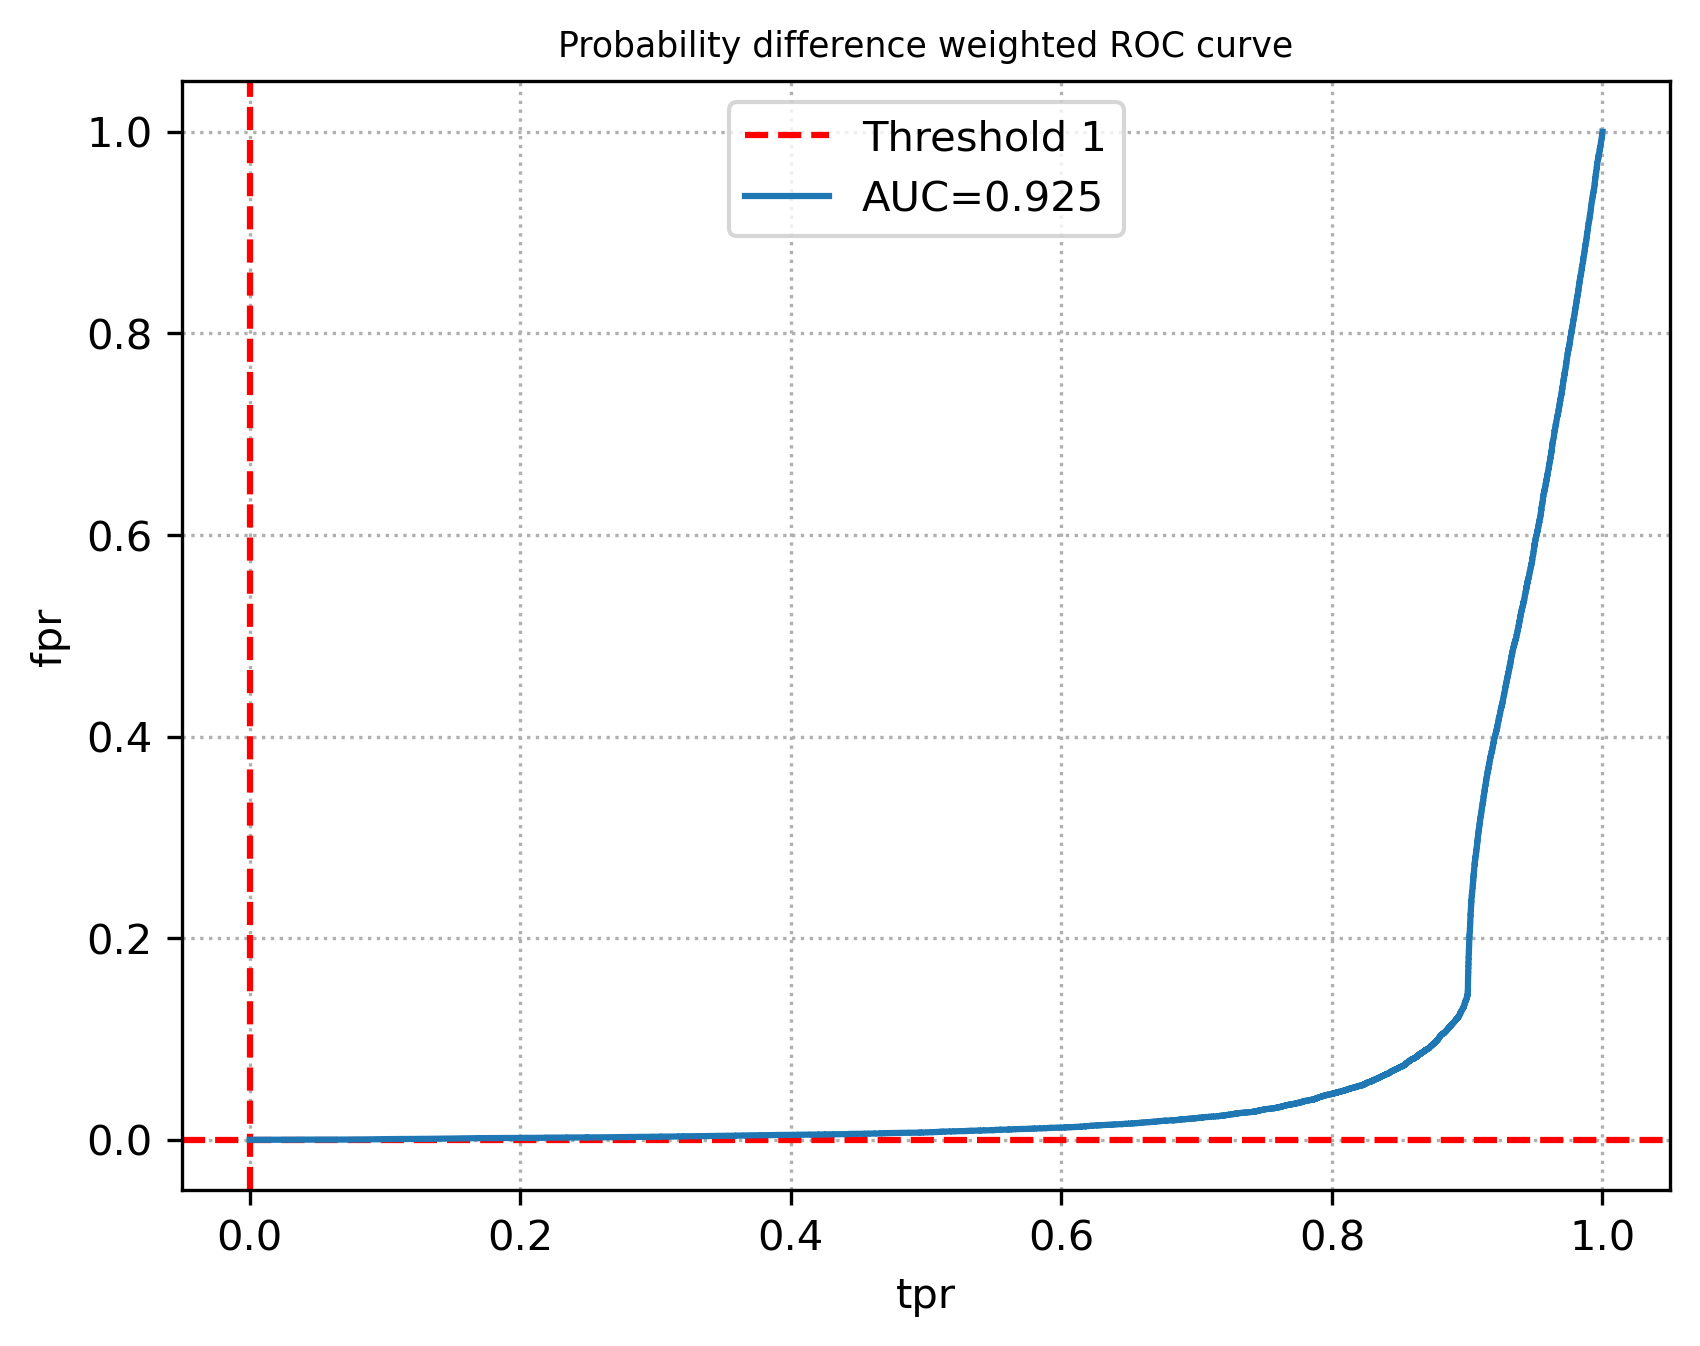

In [ ]:
true=df_test_2b_data["CLASSIFICATIONS"]["EVENT"]["signal"][()]
diff_proba= df_pred_2b_data_proba_dnn["INPUTS"]["Event"]["Probability_difference"][()]

weights= df_test_2b_data["WEIGHTS"]['weight'][()]
fpr, tpr, thresholds = roc_curve(true, diff_proba, sample_weight= weights)
score=roc_auc_score(true, diff_proba, sample_weight= weights)

desired_threshold = 1
closest_threshold_index = np.argmin(np.abs(thresholds - desired_threshold))
closest_threshold = thresholds[closest_threshold_index]
print(closest_threshold)
print(closest_threshold_index)

print(tpr[closest_threshold_index])
print(fpr[closest_threshold_index])

plt.axvline(x=tpr[closest_threshold_index], color='r', linestyle='--', label=f'Threshold {desired_threshold}')
plt.axhline(y=fpr[closest_threshold_index], color='r', linestyle='--')
plt.plot(tpr,fpr,label=f"AUC={score:.3f}")
plt.legend()
plt.xlabel("tpr")
plt.ylabel("fpr")
plt.title(f"Probability difference weighted ROC curve", fontsize= 'small')
plt.grid(linestyle=":")
plt.show()

weights_bckg [1.6909745e-07 1.6909745e-07 1.6909745e-07 ... 1.6909745e-07 1.6909745e-07
 1.6909745e-07]
1.0
1


<function matplotlib.pyplot.show(close=None, block=None)>

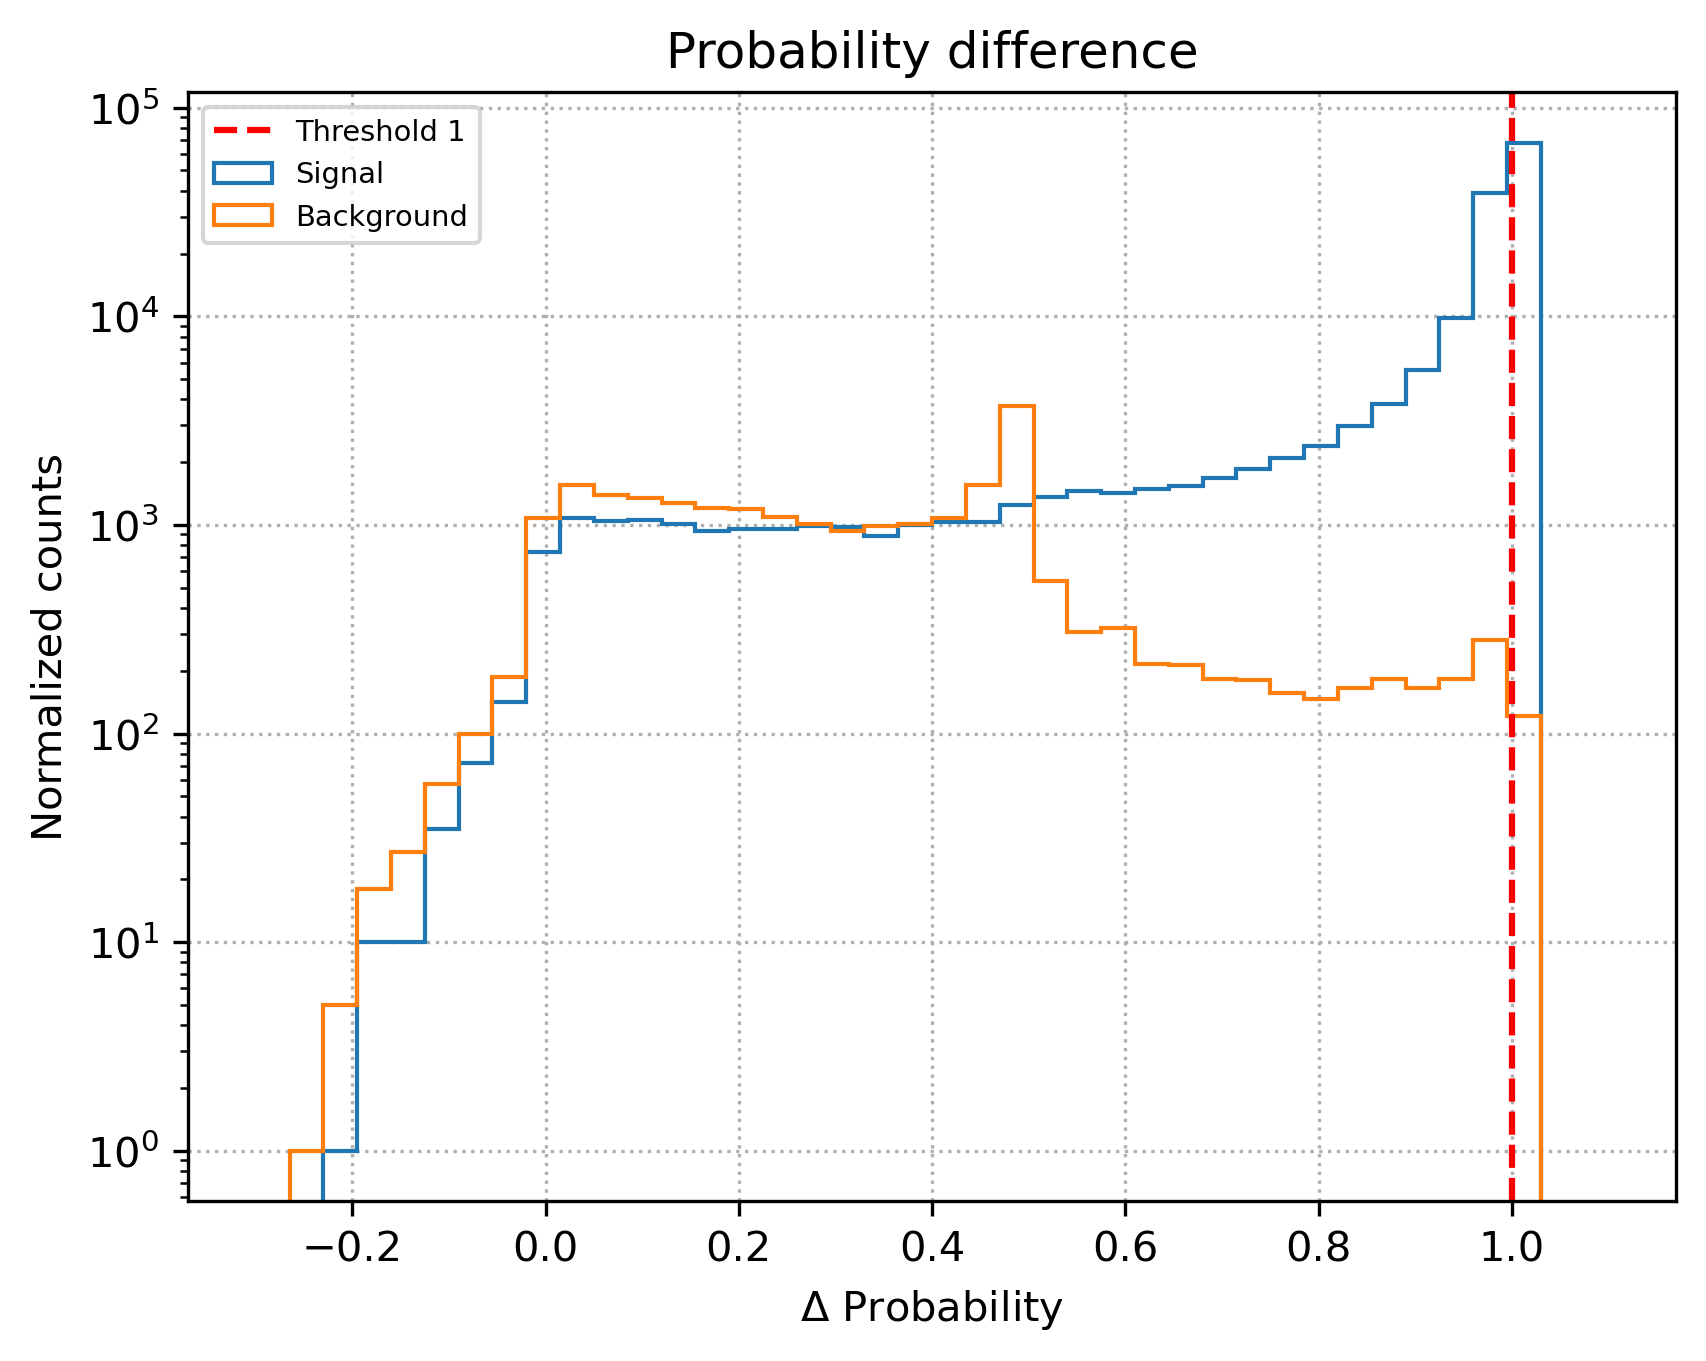

In [ ]:
mask_signal=df_test_2b_data["CLASSIFICATIONS"]["EVENT"]["signal"][()]==1
mask_background=df_test_2b_data["CLASSIFICATIONS"]["EVENT"]["signal"][()]==0
diff_proba_signal=(df_pred_2b_data_proba_dnn["INPUTS"]["Event"]["Probability_difference"][()][mask_signal])
diff_proba_bckg=(df_pred_2b_data_proba_dnn["INPUTS"]["Event"]["Probability_difference"][()][mask_background])

# for the weights we can define the signal and bckg weights that we ten apply to the histogram, respectively for the signal and the background
weights_signal= df_test_2b_data["WEIGHTS"]['weight'][()][mask_signal]
weights_bckg= df_test_2b_data["WEIGHTS"]['weight'][()][mask_background]
print("weights_bckg", weights_bckg)

desired_threshold = 1
closest_threshold_index = np.argmin(np.abs(thresholds - desired_threshold))
closest_threshold = thresholds[closest_threshold_index]
print(closest_threshold)
print(closest_threshold_index)

plt.axvline(x=closest_threshold, color='r', linestyle='--', label=f'Threshold {desired_threshold}')
plt.hist(diff_proba_signal,bins=40,range=(-0.3,1.1),histtype='step',label="Signal")
plt.hist(diff_proba_bckg,bins=40,range=(-0.3,1.1),histtype='step',label="Background")
# plt.hist(diff_proba_signal,bins=40,range=(-0.3,0),histtype='step',label="Signal weighted", density=True, weights=weights_signal)
# plt.hist(diff_proba_bckg,bins=40,range=(-0.3,0),histtype='step',label="Background weighted", density=True, weights=weights_bckg)
plt.legend(loc='upper left', fontsize="x-small")
plt.xlabel(r"$\Delta$ Probability")
plt.yscale("log")
plt.ylabel("Normalized counts")
plt.title(f"Probability difference")
plt.grid(linestyle=":")
plt.show

In [ ]:
num_above_threshold = np.sum(df_pred_2b_data_proba_dnn["INPUTS"]["Event"]["Probability_difference"][()] >= desired_threshold)

# Calculate the fraction of predictions above the threshold
fraction_above_threshold = num_above_threshold / len(df_pred_2b_data_proba_dnn["INPUTS"]["Event"]["Probability_difference"][()])

print(fraction_above_threshold)

1.0893483518159438e-05


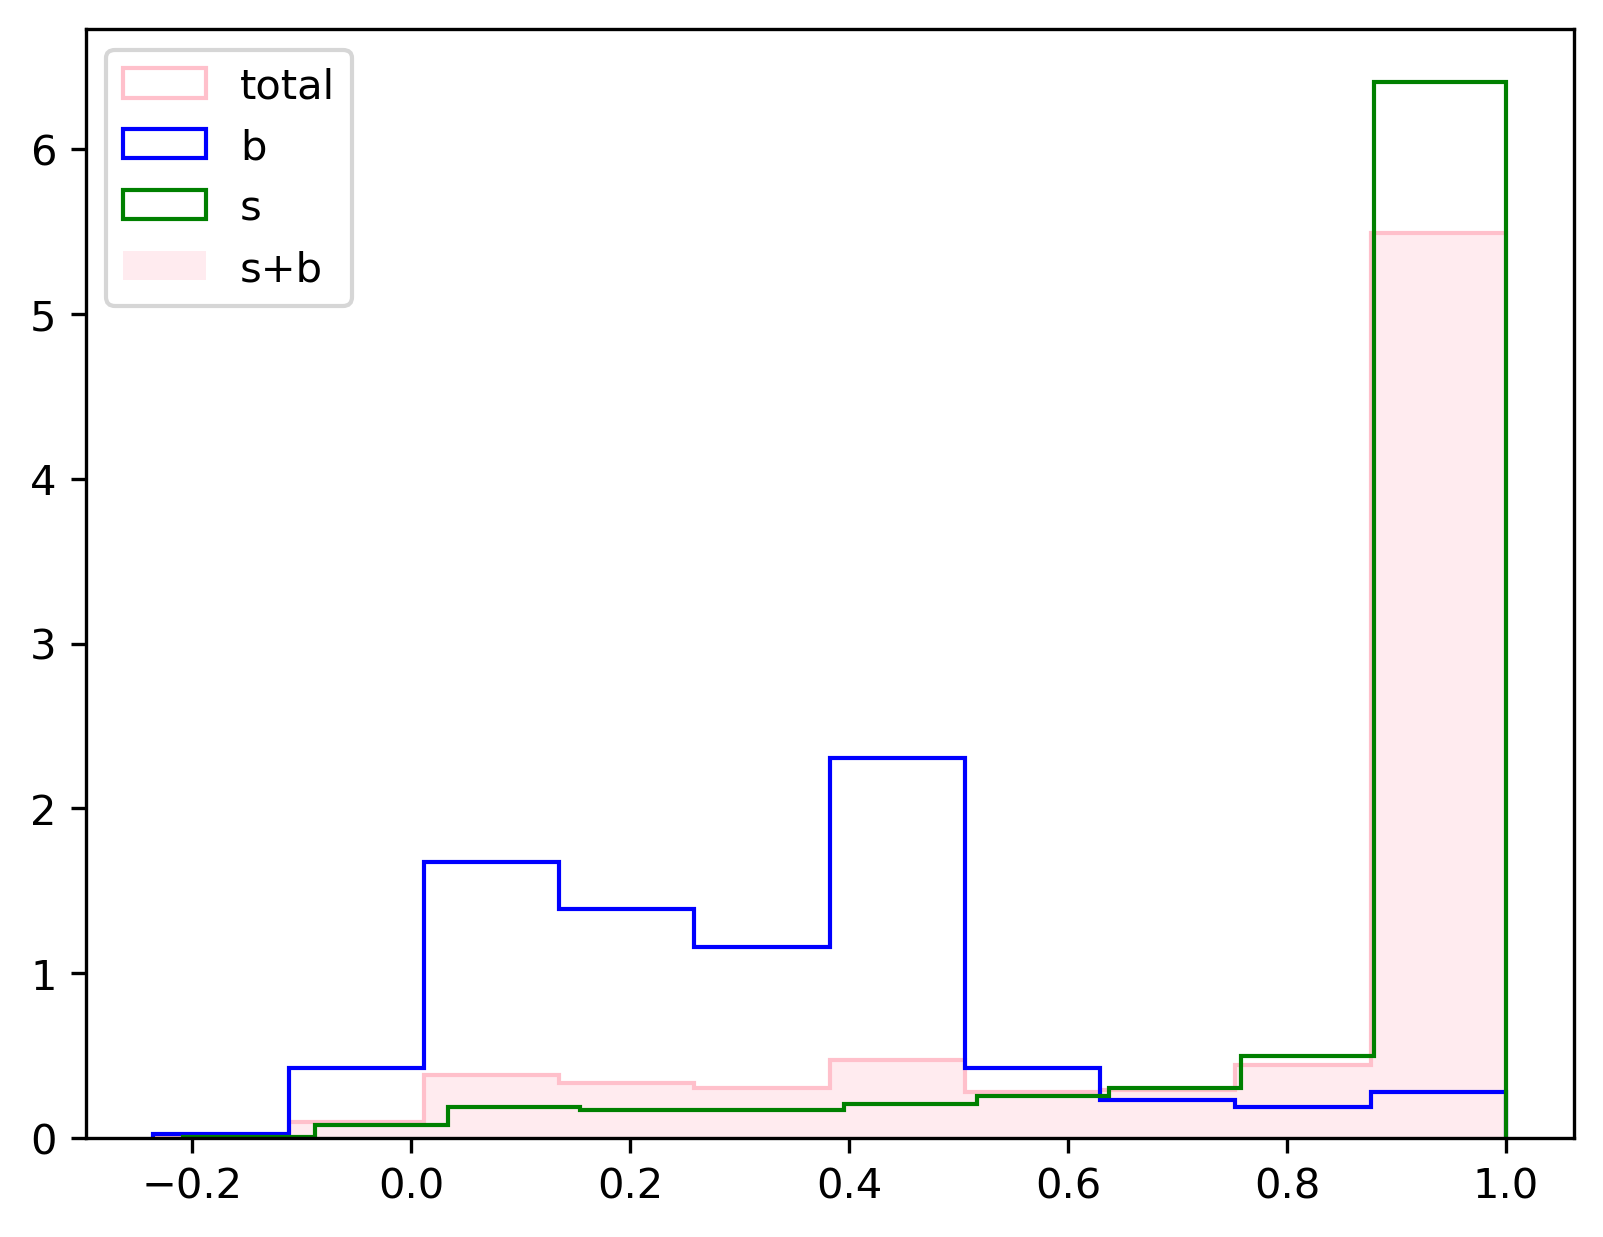

In [ ]:

var= np.concatenate((df_pred_2b_data["INPUTS"]["Event"]["Probability_difference"][()][mask_signal], df_pred_2b_data["INPUTS"]["Event"]["Probability_difference"][()][mask_background]),axis=None)

plt.hist(df_pred_2b_data["INPUTS"]["Event"]["Probability_difference"][()], label="total",histtype='step', color="pink",density= True)
plt.hist(df_pred_2b_data["INPUTS"]["Event"]["Probability_difference"][()][mask_background], label="b",histtype='step',color="b",density= True)
plt.hist(df_pred_2b_data["INPUTS"]["Event"]["Probability_difference"][()][mask_signal], label="s",histtype='step', color="g",density= True)
plt.hist(var, label="s+b",alpha=0.3,  color="pink", density= True)
plt.legend(loc="upper left")
plt.show()


max 1.0
min -0.23521286
1


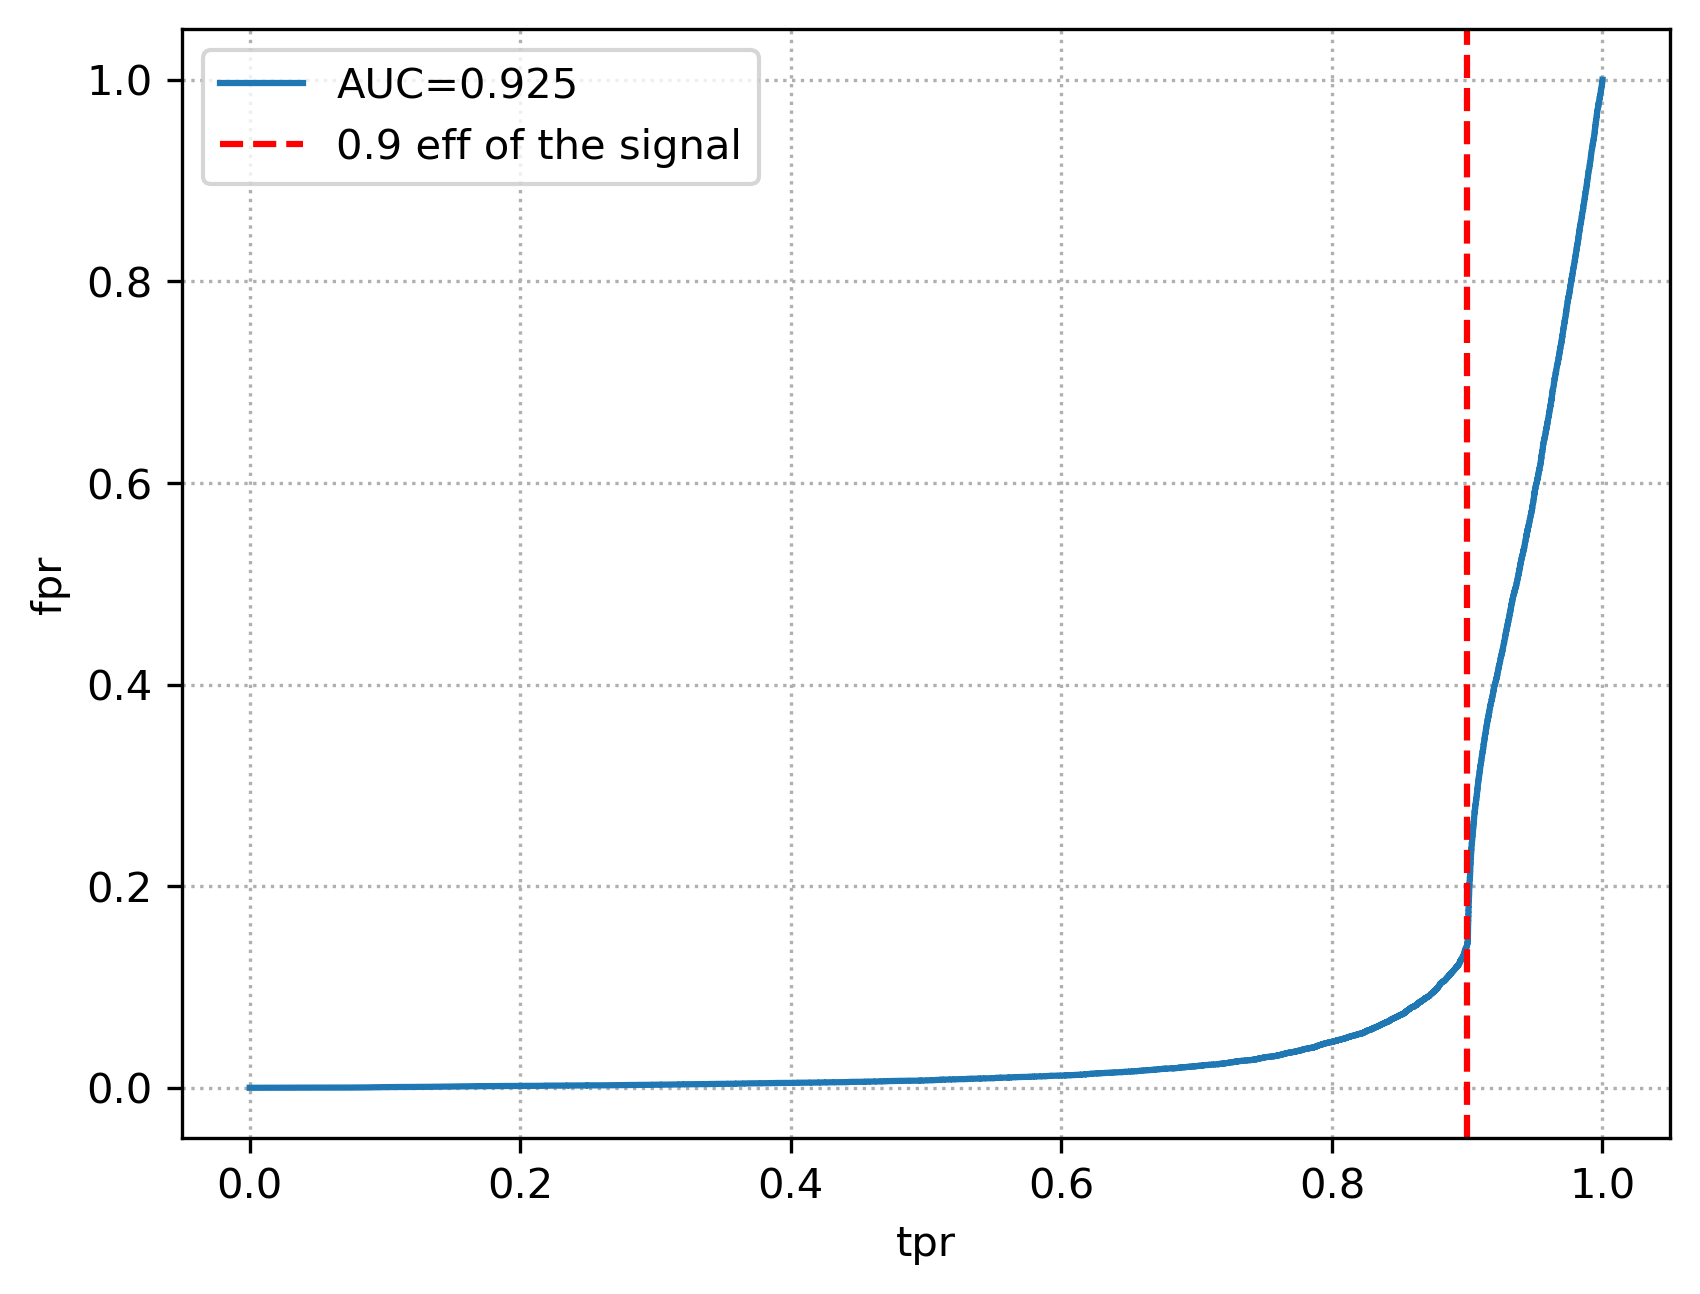

/tmp/ramellar/ipykernel_1622257/3794545432.py:61: RuntimeWarning: divide by zero encountered in arctanh
  plt.hist(np.arctanh(diff_proba_signal),bins=40,range=(-1,8),histtype='step',label="Signal weighted", weights=weights_signal,density=True)
/tmp/ramellar/ipykernel_1622257/3794545432.py:63: RuntimeWarning: divide by zero encountered in arctanh
  plt.hist(np.arctanh(diff_proba_signal),bins=40,range=(-1,8),histtype='step',label="Signal",density=True)


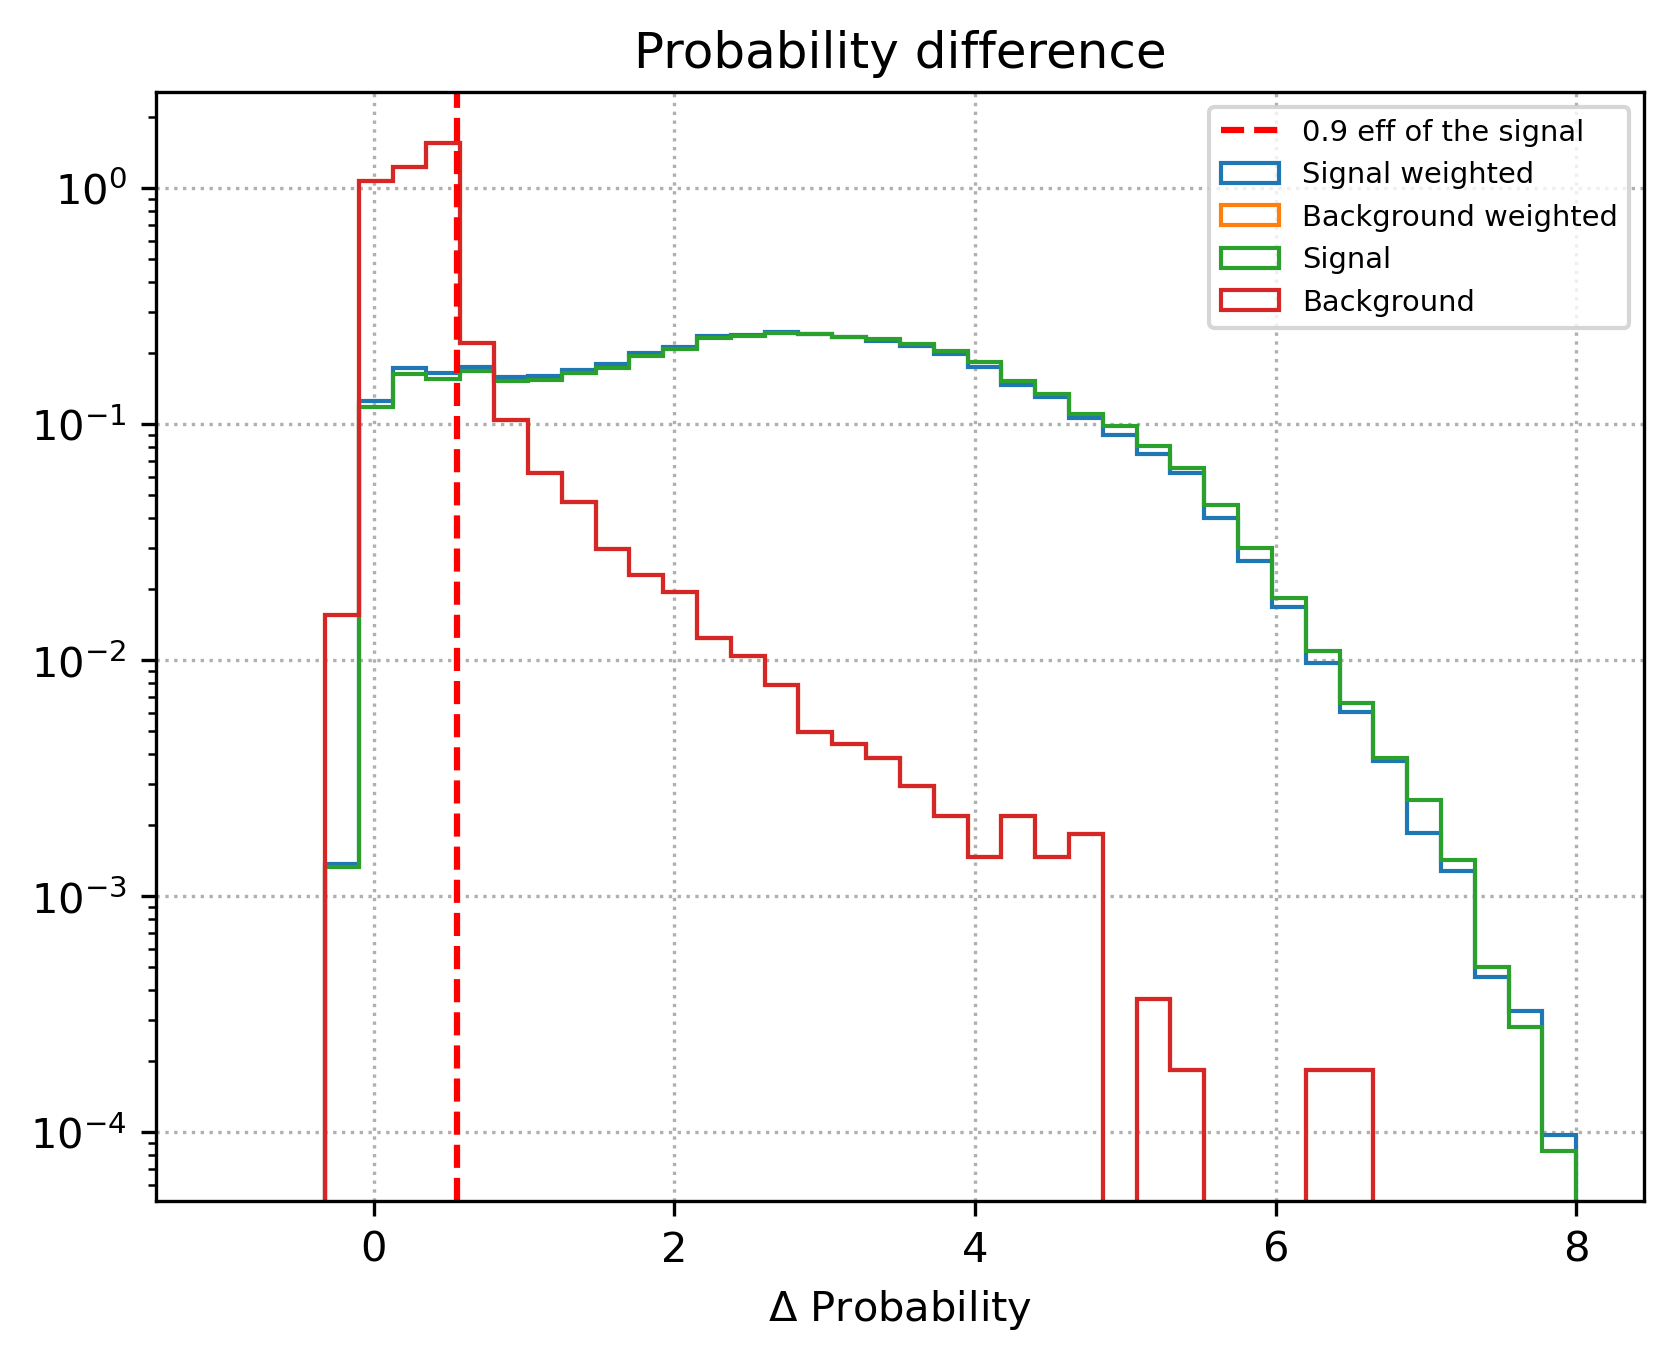

<function matplotlib.pyplot.show(close=None, block=None)>

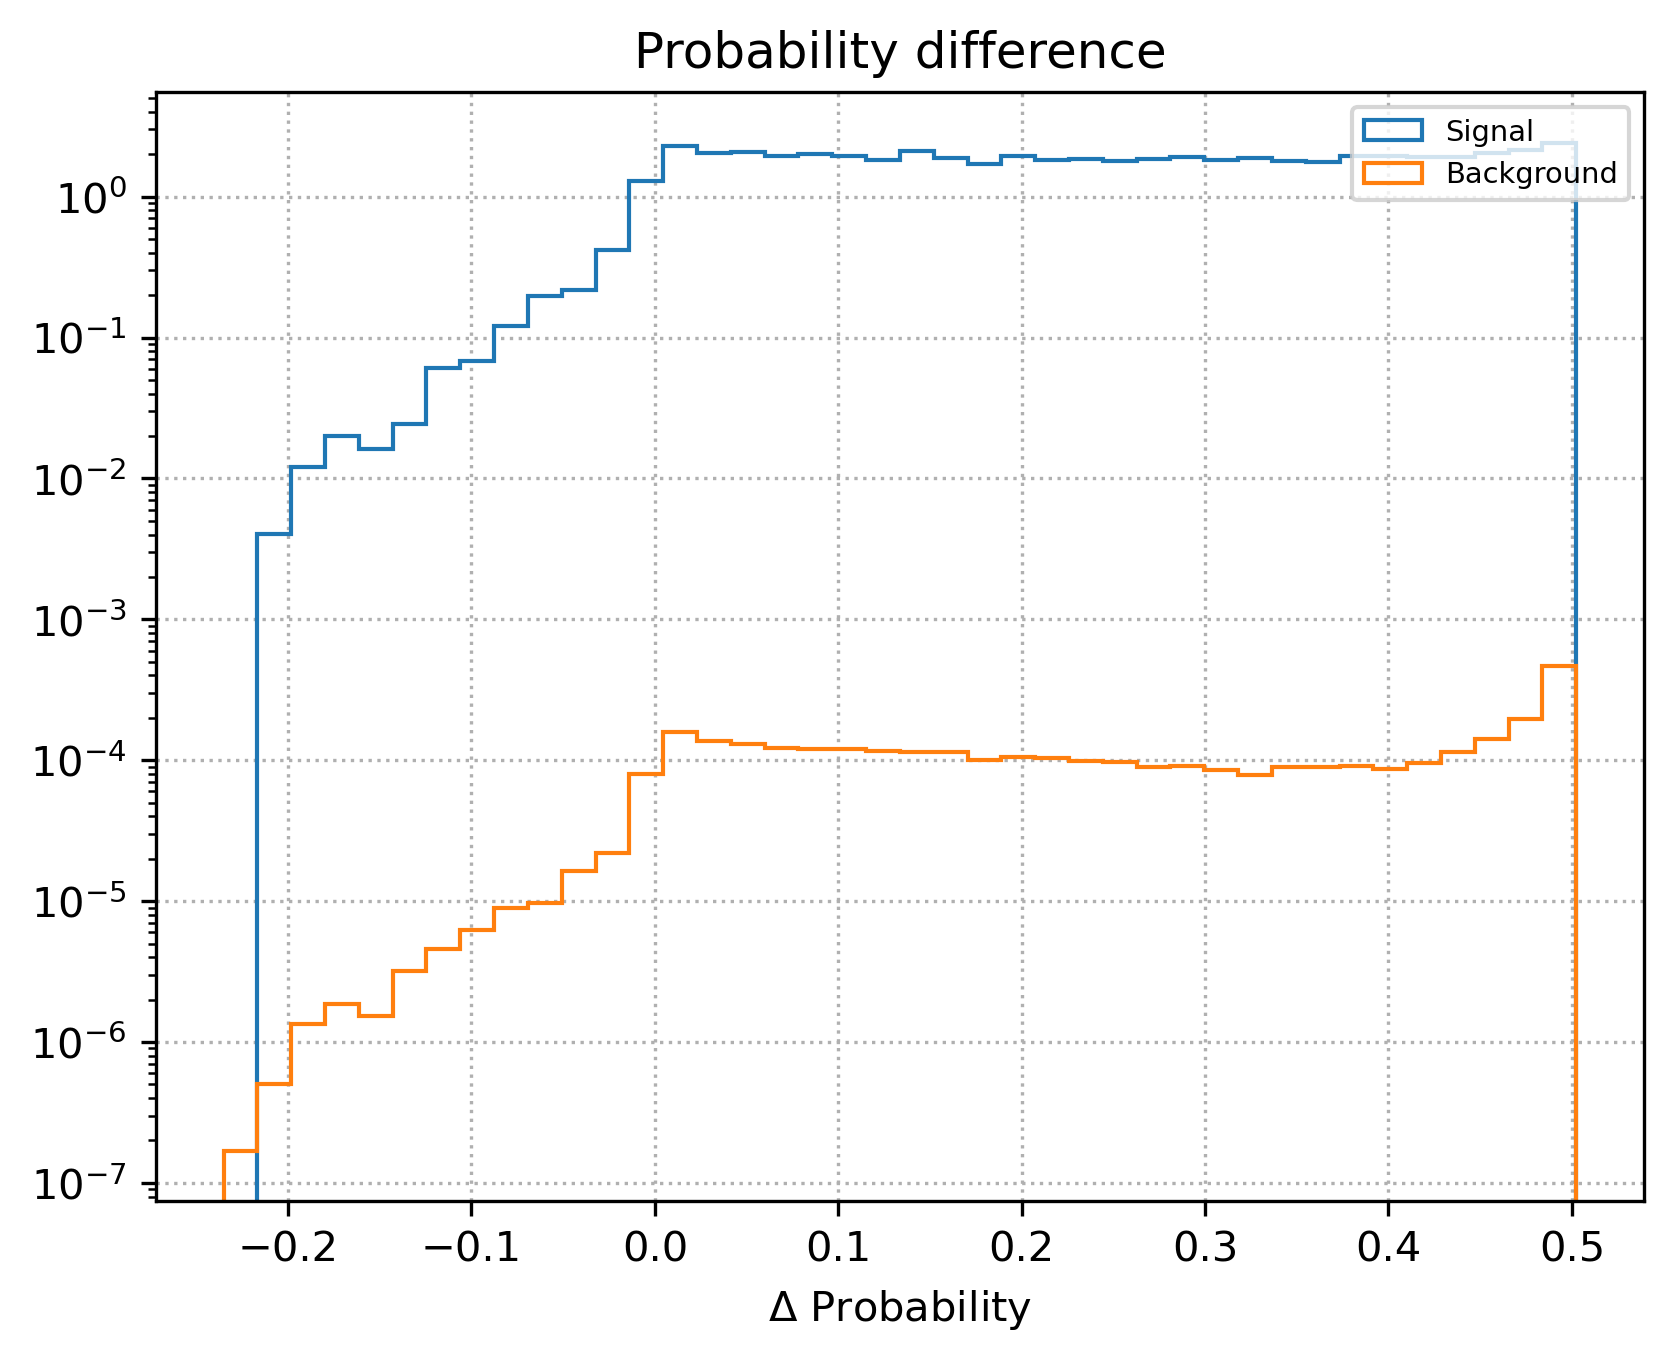

In [ ]:
mask_signal=df_test_2b_data["CLASSIFICATIONS"]["EVENT"]["signal"][()]==1
mask_background=df_test_2b_data["CLASSIFICATIONS"]["EVENT"]["signal"][()]==0
diff_proba_signal=(df_pred_2b_data_proba_dnn["INPUTS"]["Event"]["Probability_difference"][()][mask_signal])
diff_proba_bckg=(df_pred_2b_data_proba_dnn["INPUTS"]["Event"]["Probability_difference"][()][mask_background])


true= df_test_2b_data["CLASSIFICATIONS"]["EVENT"]["signal"][()]
diff_proba= df_pred_2b_data_proba_dnn["INPUTS"]["Event"]["Probability_difference"][()]

# for the weights we can define the signal and bckg weights that we ten apply to the histogram, respectively for the signal and the background
weights_signal= df_test_2b_data["WEIGHTS"]['weight'][()][mask_signal]
weights_bckg= df_test_2b_data["WEIGHTS"]['weight'][()][mask_background]
weights=df_test_2b_data["WEIGHTS"]['weight'][()]

print("max",np.max(diff_proba))
print("min",np.min(diff_proba))

fpr, tpr, thresholds= roc_curve(true, diff_proba, sample_weight= weights)

def threshold_value_min(efficiency, tpr, thresholds):
    min_eff=efficiency
    mask_sig_eff=tpr>= min_eff
    min_ind= np.argwhere(tpr==np.min(tpr[mask_sig_eff]))
    index=min_ind[0][0]
    threshold_eff =thresholds[index]
    return threshold_eff

def threshold_value_max(efficiency, tpr, thresholds):
    min_eff=efficiency
    mask_sig_eff=tpr>= min_eff
    min_ind= np.argwhere(tpr==np.min(tpr[mask_sig_eff]))
    index=min_ind[-1][0]
    threshold_eff =thresholds[index]
    return threshold_eff

min_eff=0.900
max_eff=1

th_80p=threshold_value_min(min_eff,tpr,thresholds)
th_100p=threshold_value_max(max_eff,tpr,thresholds)

print(np.sum(diff_proba<=th_100p))

mask_min=tpr > min_eff
mask_max = tpr < max_eff

score=roc_auc_score(true,diff_proba, sample_weight= weights )


plt.figure()
plt.plot(tpr, fpr, label=f"AUC={score:.3f}")
# plt.plot(tpr[mask_min & mask_max], fpr[mask_min & mask_max])
plt.axvline(x=0.900, color='r', linestyle='--', label=f'{min_eff} eff of the signal')
plt.xlabel("tpr")
plt.ylabel("fpr")
plt.grid(linestyle=":")
plt.legend()
plt.show()

plt.show()
plt.hist(np.arctanh(diff_proba_signal),bins=40,range=(-1,8),histtype='step',label="Signal weighted", weights=weights_signal,density=True)
plt.hist(np.arctanh(diff_proba_bckg),bins=40,range=(-1,8),histtype='step',label="Background weighted", weights=weights_bckg,density=True)
plt.hist(np.arctanh(diff_proba_signal),bins=40,range=(-1,8),histtype='step',label="Signal",density=True)
plt.hist(np.arctanh(diff_proba_bckg),bins=40,range=(-1,8),histtype='step',label="Background",density=True)
plt.axvline(x=np.arctanh(th_80p), color='r', linestyle='--', label=f'{min_eff} eff of the signal')
# plt.axvline(x=th_100p, color='g', linestyle='--', label=f'{max_eff} eff of the signal')

# plt.hist(diff_proba_signal,bins=40,range=(-0.3,0),histtype='step',label="Signal weighted", density=True, weights=weights_signal)
# plt.hist(diff_proba_bckg,bins=40,range=(-0.3,0),histtype='step',label="Background weighted", density=True, weights=weights_bckg)
plt.legend(loc='upper right', fontsize="x-small")
plt.xlabel(r"$\Delta$ Probability")
plt.yscale("log")
plt.title(f"Probability difference")
plt.grid(linestyle=":")
plt.show

plt.show()
plt.hist(diff_proba_signal,bins=40,range=(th_100p,th_80p),histtype='step',label="Signal", weights= weights_signal)
plt.hist(diff_proba_bckg,bins=40,range=(th_100p,th_80p),histtype='step',label="Background", weights=weights_bckg)

# plt.hist(diff_proba_signal,bins=40,range=(-0.3,0),histtype='step',label="Signal weighted", density=True, weights=weights_signal)
# plt.hist(diff_proba_bckg,bins=40,range=(-0.3,0),histtype='step',label="Background weighted", density=True, weights=weights_bckg)
plt.legend(loc='best', fontsize="x-small")
plt.xlabel(r"$\Delta$ Probability")
plt.yscale("log")
plt.title(f"Probability difference")
plt.grid(linestyle=":")
plt.show



## Computing the coefficients

In order to obtain the AUC for 4b data background we want to use the full dataset of 2b data:

$$ \text{2b-data}_f \times \frac{\text{4b-QCD}}{\text{2b-QCD}_r} \times \frac{\text{2b-QCD}_r}{\text{2b-data}_r}$$

The first ration allows to probe the b tag dependency, and the second ratio the model dependence. All the datasets in the ratios are reduced to have the same number of events as the 4b-QCD one, so that we don't depend on statistics. 

For the ROC curve, we multply the fpr array by these ratios

## Weights information



We have two types of weights:
- Event weights : given by the h5 file
- Class weights : computed by SPANet

On how the class weights are computed:

    beta = 1 - (1 / sum(event_weights))
    vector_class_weights = (1 - beta) / (1 - (beta ** torch.bincount(targets, weights=event_weights)))
    vector_class_weights[torch.isinf(vector_class_weights)] = 0
    vector_class_weights = vector_class_weights.shape[0] * vector_class_weights / vector_class_weights.sum()

    return vector_class_weights

beta is a singles value: tensor(0.9995)

sum event weights is equal to: tensor(2025.0458)

targets is tensor that i s a list of 0 and 1

torch.bincount(targets, weights=event_weights): this is going to be a tensor (which is list) with two values, the first value indicating how many "0"s there are in targets taking into account the event weight per 0, and the same for 1. So the first elemnt will correspond to bckg and the scond one to signal. 

vector_class_weights[torch.isinf(vector_class_weights)] = 0 : this sets to zero elements that migt be equal to infinity

After this, the value os the vector_class weights is tensor([6.3682e+00, 7.8112e-04])
vector_class_weights.shape[0] = 2

vector_class_weights.sum() = tensor(6.3690)

I'm not so sure why this step is done, it i snoot really an average, maybe some kind of normalisation? Probably since afterwards they are finally given by:

tensor([1.9998e+00, 2.4529e-04])

This is computed before dividing per batch as is kept the same for each batch

total weights:

4b-QCD bckg:
signal: tensor(0.4943)
bkg: tensor(0.3139)

2b-QCD bckg with reduced statistics:
total signal weights tensor(1.0008)
total background weights tensor(0.6325)

2b-data bckg with reduced statistics:
total signal weights tensor(0.0490)
total background weights tensor(0.0311)

In [ ]:
test_array=np.ndarray((2,10))
print(test_array)

sum_array_0= np.sum(test_array, axis=0)
sum_array_1= np.sum(test_array, axis=1)
# sum_array_2= np.sum(test_array, axis=2)

print("sum_array_0", sum_array_0)
print("sum_array_1", sum_array_1)
# print("sum_array_2", sum_array_2)


[[3.15501738e-53 1.09710088e-48 6.46206940e-47 1.25674382e-44
  3.97029735e-43 2.63860510e-40 2.20038910e-33 5.90535383e-34
  3.21612173e-34 2.49045784e-34]
 [1.86670360e-34 9.13271510e-35 4.46595610e-35 2.02270461e-35
  1.51580596e-35 2.10274039e-35 2.20945668e-35 3.77230652e-35
  9.82693604e-34 1.73005832e-29]]
sum_array_0 [1.86670360e-34 9.13271510e-35 4.46595610e-35 2.02270461e-35
 1.51580600e-35 2.10276678e-35 2.22248367e-33 6.28258448e-34
 1.30430578e-33 1.73008323e-29]
sum_array_1 [3.36158270e-33 1.73020048e-29]


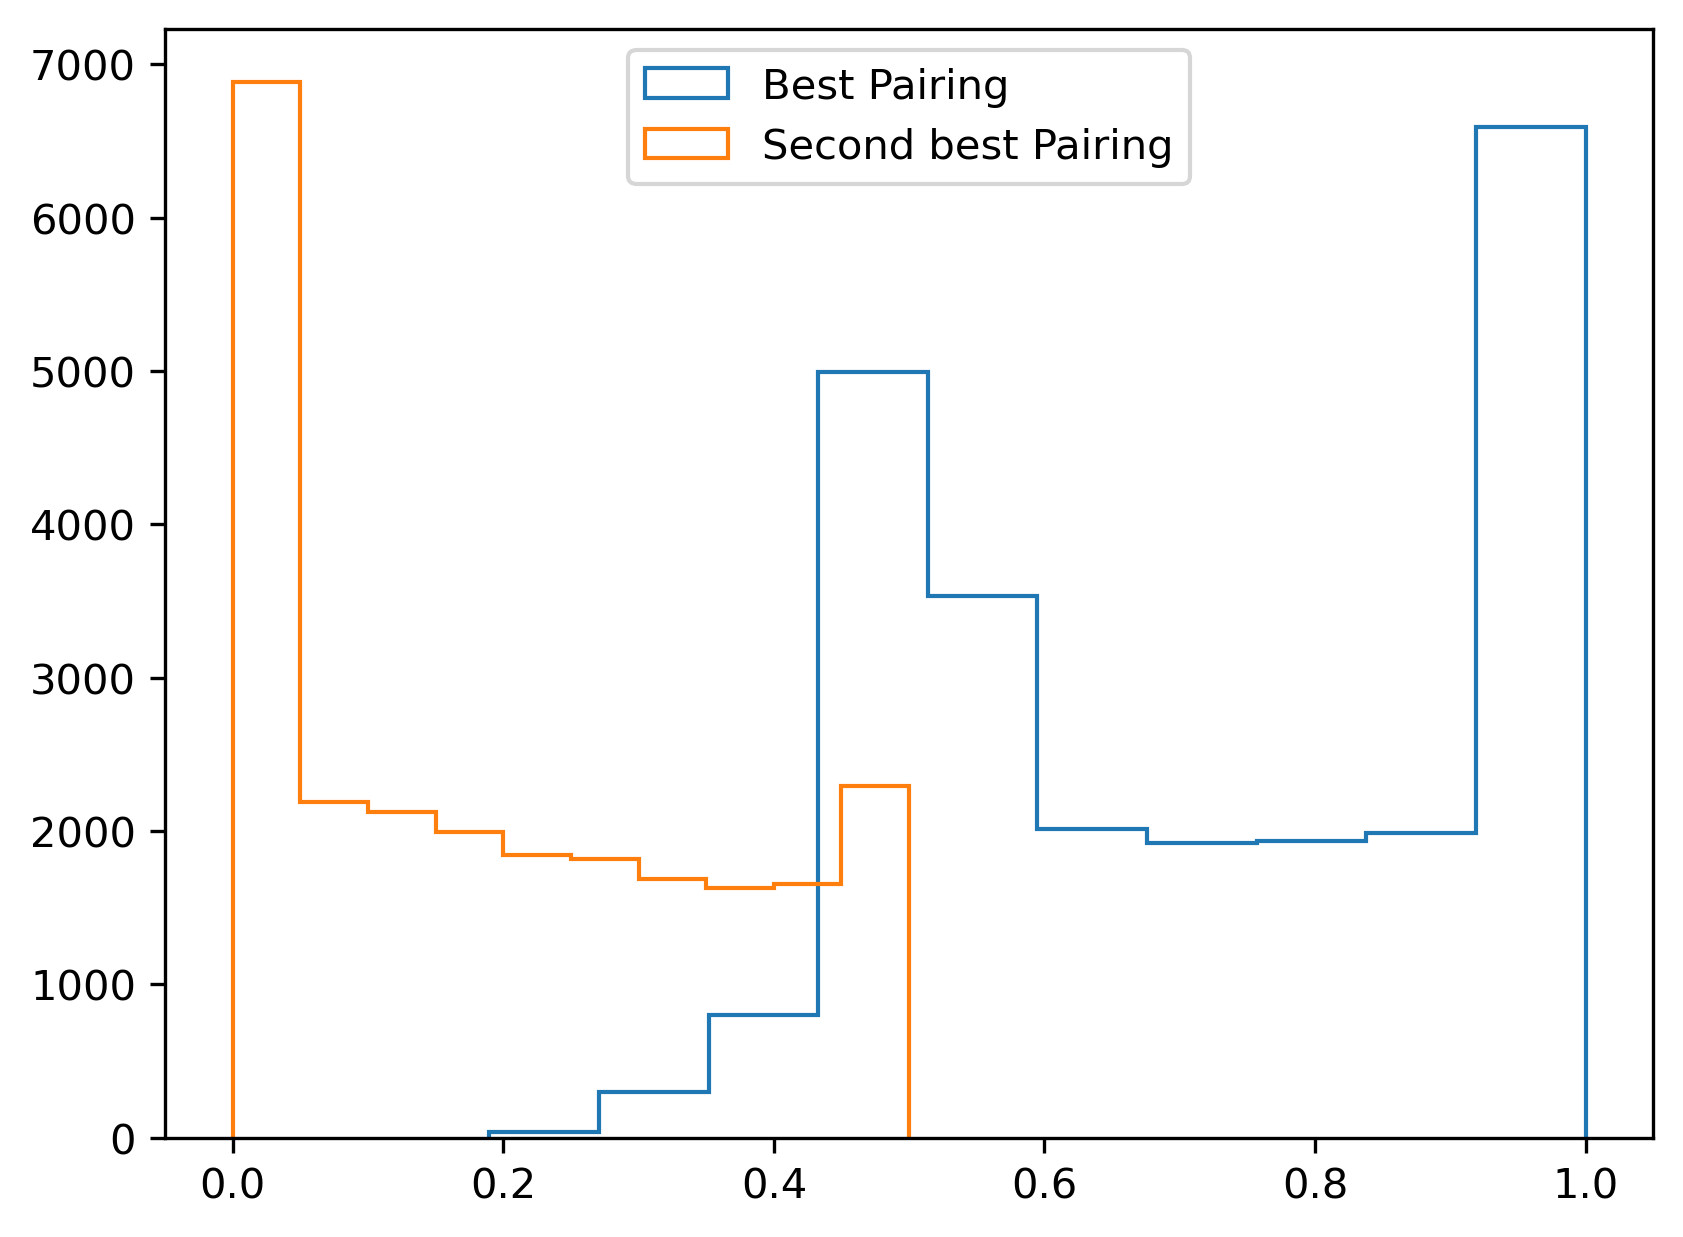

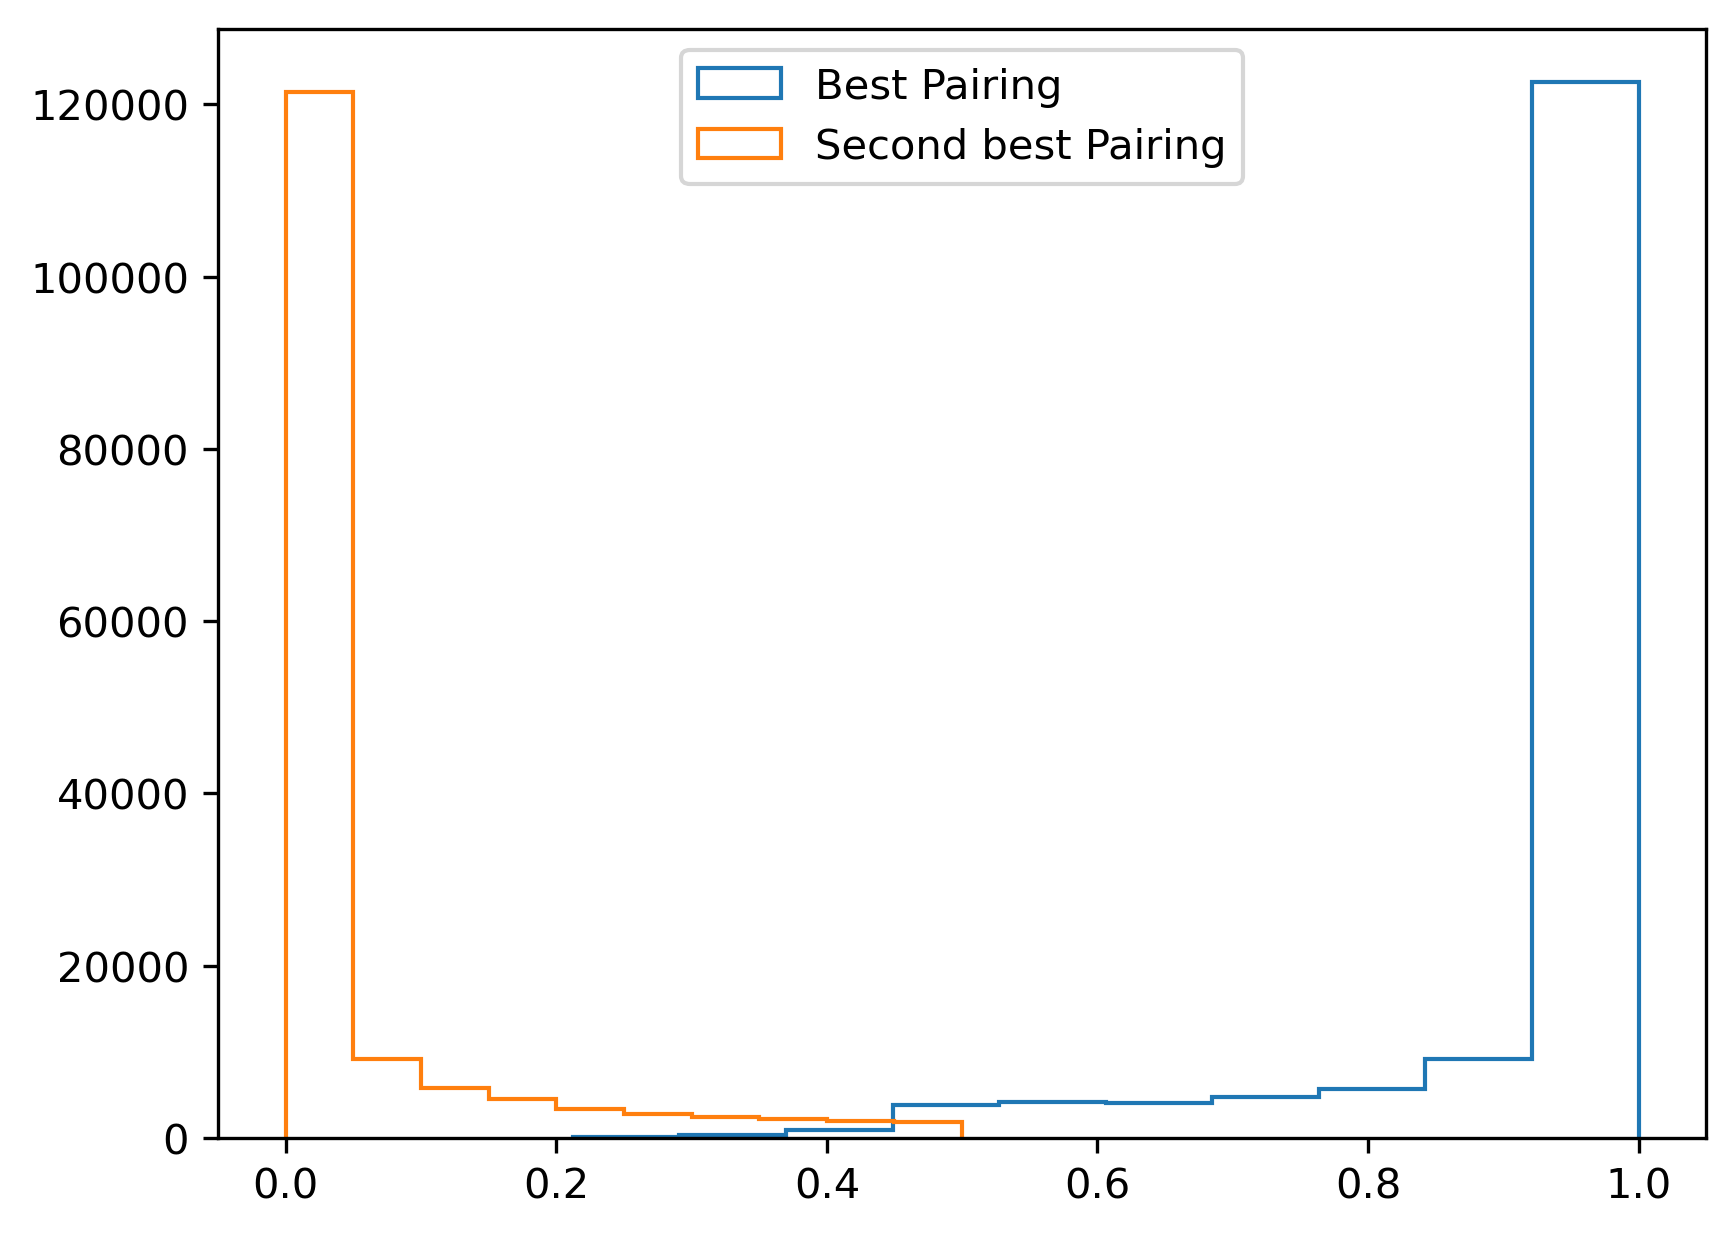

In [24]:
mask_signal=df_test_4b_QCD["CLASSIFICATIONS"]["EVENT"]["signal"][()]==1
mask_background=df_test_4b_QCD["CLASSIFICATIONS"]["EVENT"]["signal"][()]==0

df_test_4b_QCD["INPUTS"]["Event"]["Probability_difference"][()]
best=df_test_4b_QCD["INPUTS"]["Event"]["Best_pairing_probabilities_sum"][()][mask_background]
sbest= df_test_4b_QCD["INPUTS"]["Event"]["Second_best_pairing_probabilities"][()][mask_background]
best_s=df_test_4b_QCD["INPUTS"]["Event"]["Best_pairing_probabilities_sum"][()][mask_signal]
sbest_s= df_test_4b_QCD["INPUTS"]["Event"]["Second_best_pairing_probabilities"][()][mask_signal]

plt.hist(best, histtype="step", label= "Best Pairing")
plt.hist(sbest, histtype="step", label= "Second best Pairing")
plt.legend(loc="upper center")
plt.show()

plt.hist(best_s, histtype="step",label= "Best Pairing")
plt.hist(sbest_s, histtype="step", label= "Second best Pairing")
plt.legend(loc="upper center")
plt.show()

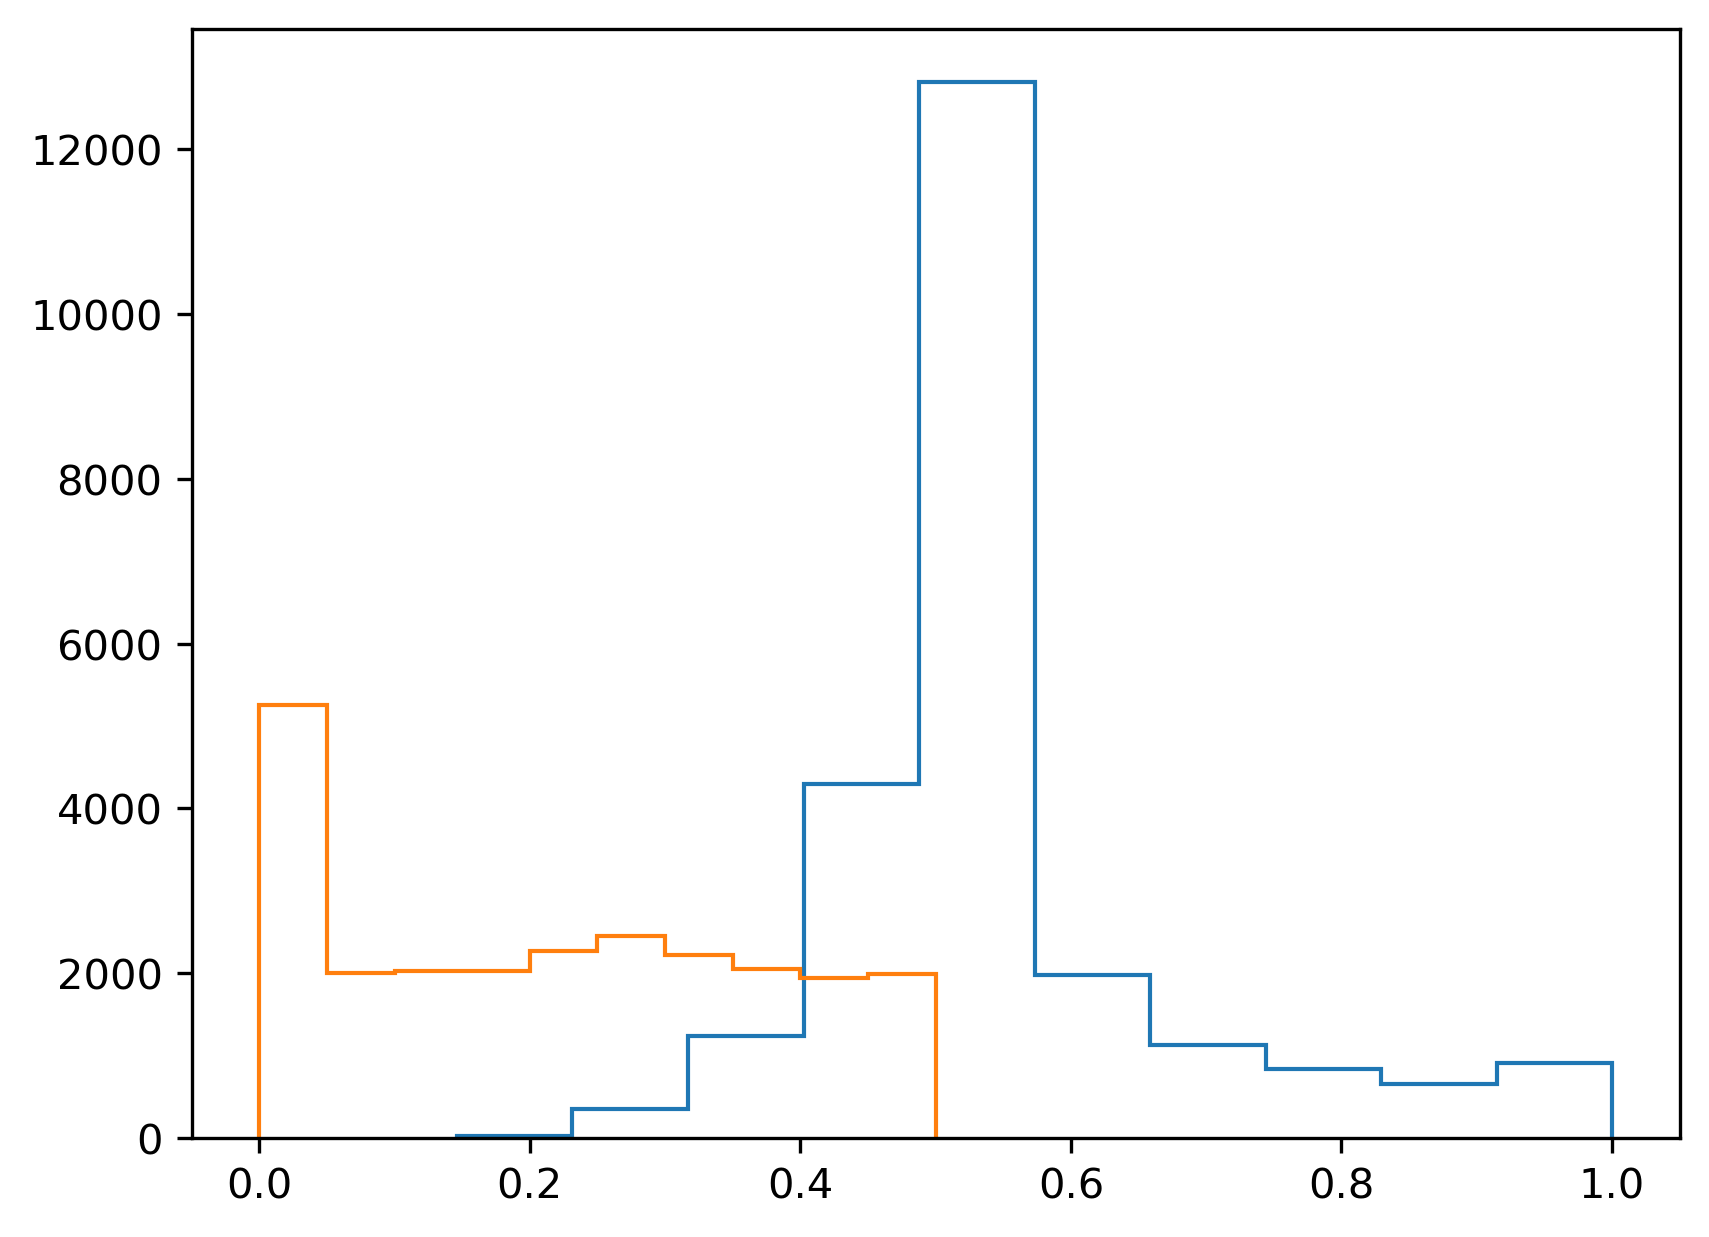

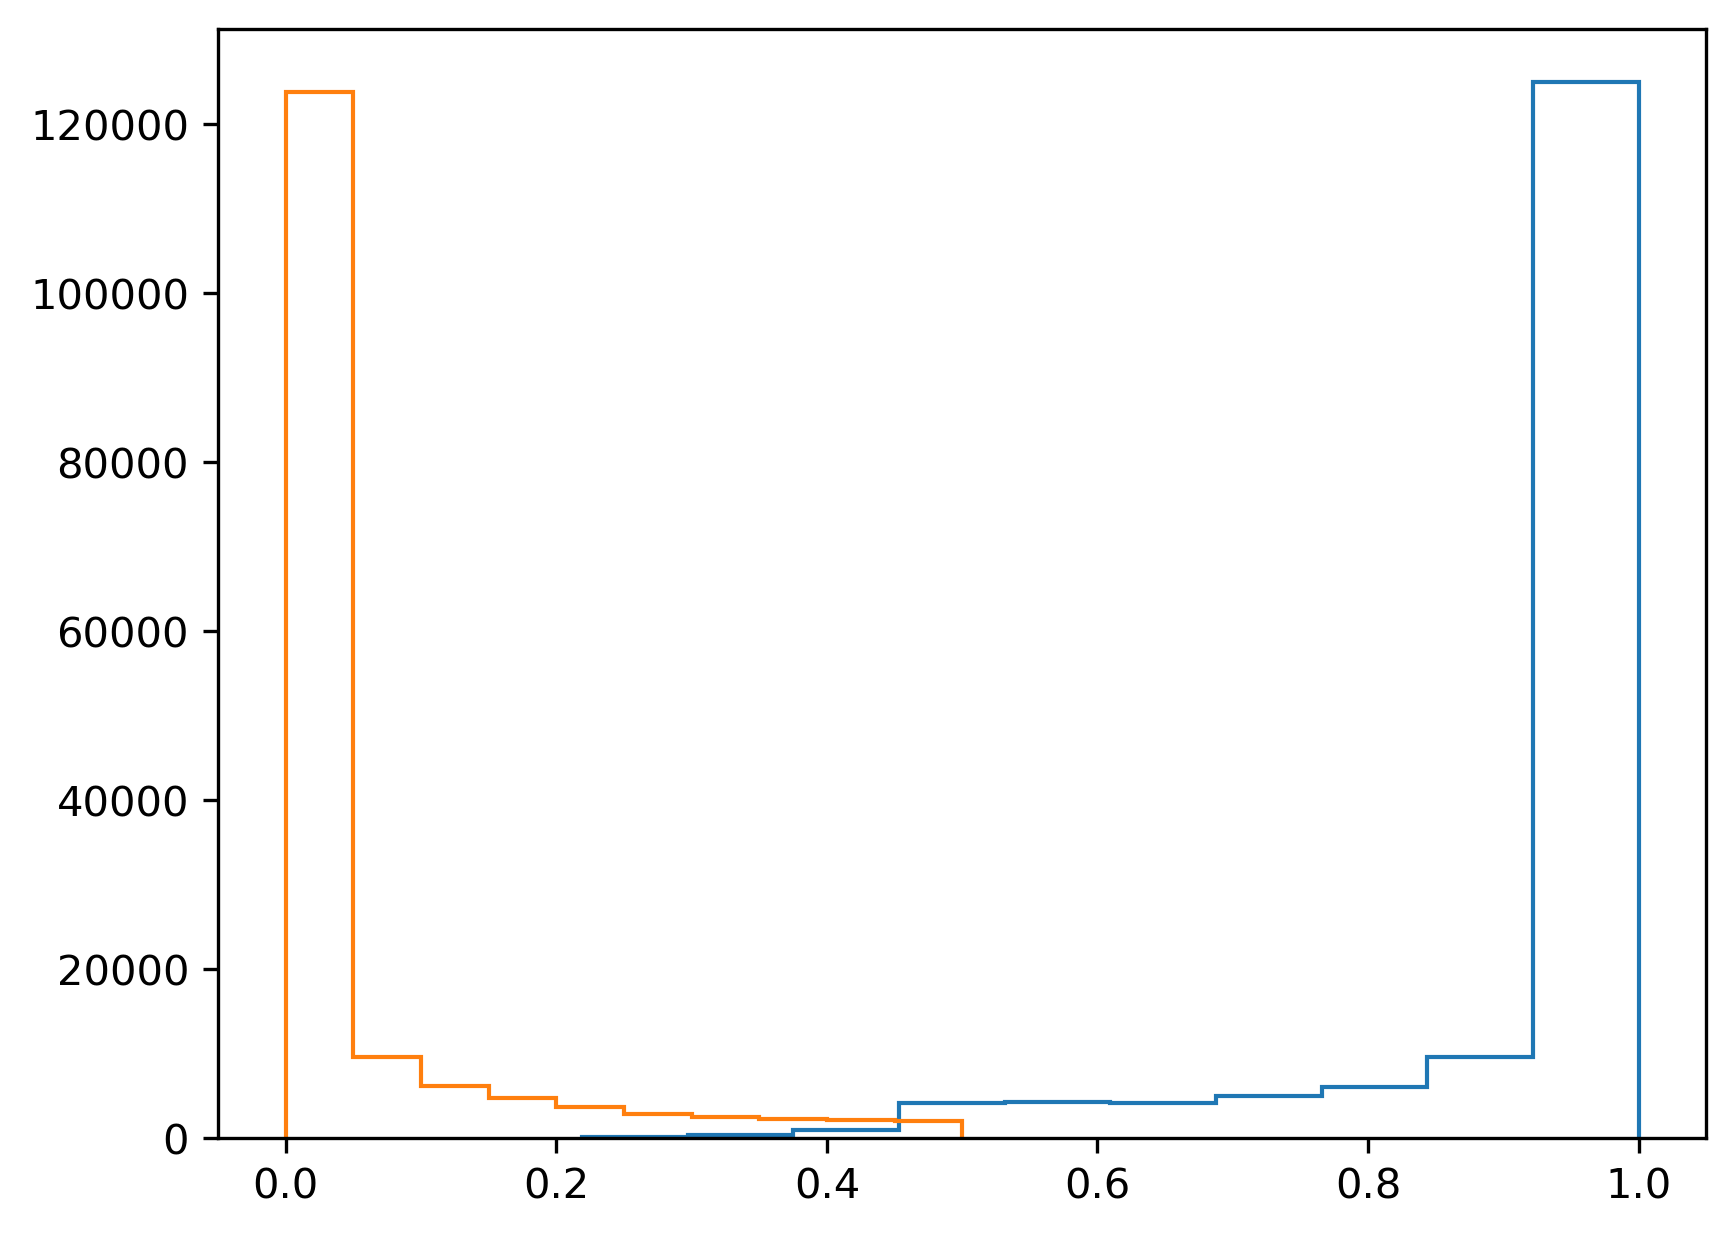

In [ ]:
mask_signal=df_test_2b_data["CLASSIFICATIONS"]["EVENT"]["signal"][()]==1
mask_background=df_test_2b_data["CLASSIFICATIONS"]["EVENT"]["signal"][()]==0

df_test_2b_data["INPUTS"]["Event"]["Probability_difference"][()]
best=df_test_2b_data["INPUTS"]["Event"]["Best_pairing_probabilities_sum"][()][mask_background]
sbest= df_test_2b_data["INPUTS"]["Event"]["Second_best_pairing_probabilities"][()][mask_background]
best_s=df_test_2b_data["INPUTS"]["Event"]["Best_pairing_probabilities_sum"][()][mask_signal]
sbest_s= df_test_2b_data["INPUTS"]["Event"]["Second_best_pairing_probabilities"][()][mask_signal]

plt.hist(best, histtype="step", label= "Best pairing")
plt.hist(sbest, histtype="step", label= "Second best pairing")
plt.show()

plt.hist(best_s, histtype="step", label= "Best pairing")
plt.hist(sbest_s, histtype="step", label= "Second best pairing")
plt.show()